## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 3.31 and accuracy of 0.14
Iteration 100: with minibatch training loss = 2.32 and accuracy of 0.5
Iteration 200: with minibatch training loss = 1.83 and accuracy of 0.55
Iteration 300: with minibatch training loss = 1.88 and accuracy of 0.59
Iteration 400: with minibatch training loss = 1.62 and accuracy of 0.64
Iteration 500: with minibatch training loss = 1.49 and accuracy of 0.59
Iteration 600: with minibatch training loss = 1.68 and accuracy of 0.58
Iteration 700: with minibatch training loss = 1.45 and accuracy of 0.58
Epoch 1, Overall loss = 1.81 and accuracy of 0.583


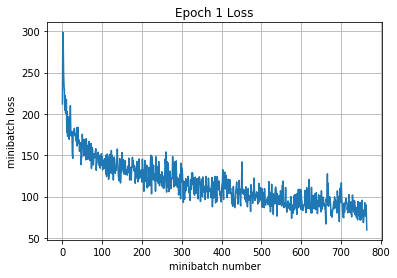

Validation
Epoch 1, Overall loss = 1.48 and accuracy of 0.609


In [40]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False, needShuffle = True):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    if needShuffle: np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
                if np.sum(corr)/actual_batch_size >= 0.98:
                    break #the model reach the trainning optimal
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct,correct_prediction

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [9]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define model
def complex_model(X,y,is_training):
    # Set up variables
    Wconv1 = tf.get_variable("Wconv1",shape=[7,7,3,32])
    bconv1 = tf.get_variable("bconv1",shape=[32])
    Waffine1 = tf.get_variable("Waffine1", shape=[5408,1024])
    baffine1 = tf.get_variable("baffine1", shape=[1024])
    Waffine2 = tf.get_variable("Waffine2", shape=[1024,10])
    baffine2 = tf.get_variable("baffine2", shape=[10])
    
    # Define model
    c1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
    r1 = tf.nn.relu(c1)
    bn1 = tf.layers.batch_normalization(r1, training=is_training) 
    p1 = tf.nn.max_pool(bn1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    f1 = tf.reshape(p1,[-1,5408])
    a1 = tf.matmul(f1, Waffine1) + baffine1
    r2 = tf.nn.relu(a1)
    y_out = tf.matmul(r2, Waffine2) + baffine2
    return y_out

y_out = complex_model(X,y,is_training)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [10]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

157 ms ± 3.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [11]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

no gpu found, please use Google Cloud if you want GPU acceleration


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [12]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10), logits=y_out))
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [13]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [14]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 3.12 and accuracy of 0.047
Iteration 100: with minibatch training loss = 2.33 and accuracy of 0.44
Iteration 200: with minibatch training loss = 1.73 and accuracy of 0.42
Iteration 300: with minibatch training loss = 1.97 and accuracy of 0.39
Iteration 400: with minibatch training loss = 1.38 and accuracy of 0.41
Iteration 500: with minibatch training loss = 1.67 and accuracy of 0.47
Iteration 600: with minibatch training loss = 1.22 and accuracy of 0.62
Iteration 700: with minibatch training loss = 1.21 and accuracy of 0.59
Epoch 1, Overall loss = 1.67 and accuracy of 0.453


(1.6699666781133535, 0.453)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [15]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.4 and accuracy of 0.537


(1.3957149877548218, 0.537)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [65]:
# # Feel free to play with this cell

# #crb crb mp crb crb mp f frb f


# Wconv1 = tf.get_variable("Wconv1", shape=[5, 5, 3, 32])
# bconv1 = tf.get_variable("bconv1", shape=[32])
# Wconv2 = tf.get_variable("Wconv2", shape=[5, 5, 32, 64])
# bconv2 = tf.get_variable("bconv2", shape=[64])

# W1 = tf.get_variable("W1", shape=[4096, 1024])
# b1 = tf.get_variable("b1", shape=[1024])
# W2 = tf.get_variable("W2", shape=[1024, 10])
# b2 = tf.get_variable("b2", shape=[10])

# step = tf.Variable(0)

# def my_model(X,y,is_training):
#     # crb
#     c1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='SAME') + bconv1
#     bc1 = tf.layers.batch_normalization(c1, center=True, scale=True,  training=is_training)
#     r1 = tf.nn.relu(bc1)
#     p1 = tf.nn.max_pool(r1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
#     # mp
    
#     # crb
#     c2 = tf.layers.conv2d(X,Wconv2, padding='same', strides=1) + bconv2
#     bc2 = tf.layers.batch_normalization(c2, center=True, scale=True,  training=is_training)
#     r2 = tf.nn.relu(bc2)
#     p2 = tf.nn.max_pool(r2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
#     # f
#     f1 = tf.reshape(p2,[-1,4096])
#     # frb
#     h1 = tf.matmul(conv_flat,W1) + b1
#     bh1 = tf.layers.batch_normalization(h1, center=True, scale=True,  training=is_training)
#     r3 = tf.nn.relu(bh1)
#     y_out = tf.matmul(r3,W2) + b2
    
#     return y_out
#     pass

# tf.reset_default_graph()

# X = tf.placeholder(tf.float32, [None, 32, 32, 3])
# y = tf.placeholder(tf.int64, [None])
# is_training = tf.placeholder(tf.bool)

# y_out = my_model(X,y,is_training)
# mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10), logits=y_out))
# mean_loss += 0.001 * (tf.nn.l2_loss(Wconv1) + tf.nn.l2_loss(Wconv2) + tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2))

# learning_rate = tf.train.exponential_decay(0.001, step, 100, 0.9, staircase=True)
# optimizer = tf.train.AdamOptimizer(learning_rate)

# # batch normalization in tensorflow requires this extra dependency
# extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(extra_update_ops):
#     train_step = optimizer.minimize(mean_loss)

# https://github.com/Observerspy/CS231n/blob/master/assignment2/TensorFlow.ipynb

# Feel free to play with this cell

def my_model(X,y,is_training):
    x = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='SAME') + bconv1
    x = tf.layers.batch_normalization(x, center=True, scale=True,  training=is_training)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    x = tf.nn.conv2d(x, Wconv2, strides=[1,1,1,1], padding='SAME') + bconv2
    x = tf.layers.batch_normalization(x, center=True, scale=True,  training=is_training)
    x = tf.nn.relu(x)
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    x = tf.reshape(x,[-1,4096])
    x = tf.matmul(x,W1) + b1
    x = tf.layers.batch_normalization(x, center=True, scale=True,  training=is_training)
    x = tf.nn.relu(x)
    return tf.matmul(x,W2) + b2

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
global_step = tf.Variable(0)

Wconv1 = tf.get_variable("Wconv1", shape=[5, 5, 3, 32])
bconv1 = tf.get_variable("bconv1", shape=[32])
Wconv2 = tf.get_variable("Wconv2", shape=[5, 5, 32, 64])
bconv2 = tf.get_variable("bconv2", shape=[64])

W1 = tf.get_variable("W1", shape=[4096, 1024])
b1 = tf.get_variable("b1", shape=[1024])
W2 = tf.get_variable("W2", shape=[1024, 10])
b2 = tf.get_variable("b2", shape=[10])
    
    
y_out = my_model(X,y,is_training)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10), logits=y_out))
mean_loss += 0.001 * (tf.nn.l2_loss(Wconv1) + tf.nn.l2_loss(Wconv2) + tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2))

learning_rate = tf.train.exponential_decay(0.001, global_step, 100, 0.9, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss, global_step=global_step)




Training
Iteration 0: with minibatch training loss = 3.51 and accuracy of 0.094
Iteration 100: with minibatch training loss = 2.08 and accuracy of 0.56
Iteration 200: with minibatch training loss = 1.76 and accuracy of 0.67
Iteration 300: with minibatch training loss = 2.04 and accuracy of 0.48
Iteration 400: with minibatch training loss = 1.49 and accuracy of 0.66
Iteration 500: with minibatch training loss = 1.38 and accuracy of 0.69
Iteration 600: with minibatch training loss = 1.17 and accuracy of 0.73
Iteration 700: with minibatch training loss = 1.29 and accuracy of 0.67
Epoch 1, Overall loss = 1.79 and accuracy of 0.576


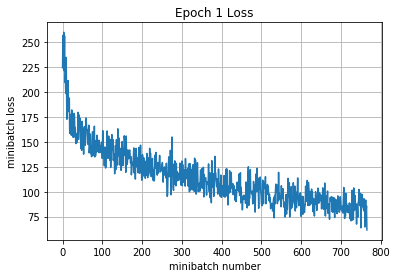

Iteration 800: with minibatch training loss = 1.01 and accuracy of 0.75
Iteration 900: with minibatch training loss = 1.06 and accuracy of 0.75
Iteration 1000: with minibatch training loss = 1.23 and accuracy of 0.75
Iteration 1100: with minibatch training loss = 1.46 and accuracy of 0.61
Iteration 1200: with minibatch training loss = 0.848 and accuracy of 0.8
Iteration 1300: with minibatch training loss = 0.891 and accuracy of 0.81
Iteration 1400: with minibatch training loss = 1.03 and accuracy of 0.8
Iteration 1500: with minibatch training loss = 0.952 and accuracy of 0.83
Epoch 2, Overall loss = 1.07 and accuracy of 0.732


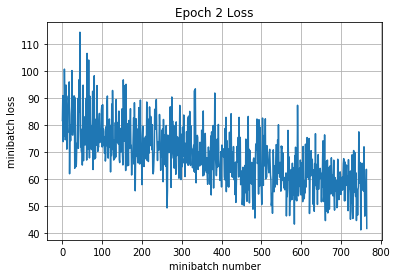

Iteration 1600: with minibatch training loss = 0.712 and accuracy of 0.83
Iteration 1700: with minibatch training loss = 0.916 and accuracy of 0.78
Iteration 1800: with minibatch training loss = 0.717 and accuracy of 0.84
Iteration 1900: with minibatch training loss = 0.703 and accuracy of 0.84
Iteration 2000: with minibatch training loss = 0.613 and accuracy of 0.89
Iteration 2100: with minibatch training loss = 0.779 and accuracy of 0.77
Iteration 2200: with minibatch training loss = 0.616 and accuracy of 0.86
Epoch 3, Overall loss = 0.74 and accuracy of 0.833


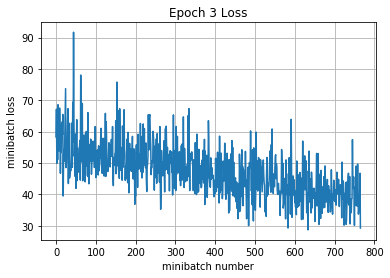

Iteration 2300: with minibatch training loss = 0.542 and accuracy of 0.89
Iteration 2400: with minibatch training loss = 0.622 and accuracy of 0.88
Iteration 2500: with minibatch training loss = 0.596 and accuracy of 0.89
Iteration 2600: with minibatch training loss = 0.624 and accuracy of 0.86
Iteration 2700: with minibatch training loss = 0.486 and accuracy of 0.92
Iteration 2800: with minibatch training loss = 0.497 and accuracy of 0.94
Iteration 2900: with minibatch training loss = 0.414 and accuracy of 0.95
Iteration 3000: with minibatch training loss = 0.454 and accuracy of 0.94
Epoch 4, Overall loss = 0.521 and accuracy of 0.912


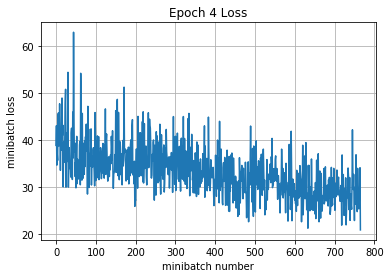

Iteration 3100: with minibatch training loss = 0.424 and accuracy of 0.97
Iteration 3200: with minibatch training loss = 0.426 and accuracy of 0.95
Iteration 3300: with minibatch training loss = 0.464 and accuracy of 0.94
Iteration 3400: with minibatch training loss = 0.363 and accuracy of 0.97
Iteration 3500: with minibatch training loss = 0.328 and accuracy of 0.97
Iteration 3600: with minibatch training loss = 0.418 and accuracy of 0.92
Iteration 3700: with minibatch training loss = 0.421 and accuracy of 0.97
Iteration 3800: with minibatch training loss = 0.329 and accuracy of 1
Epoch 5, Overall loss = 0.39 and accuracy of 0.919


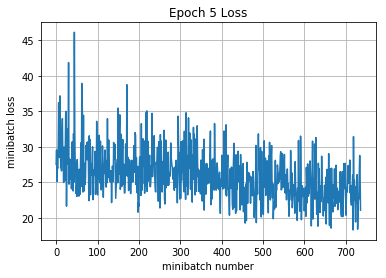

Iteration 3800: with minibatch training loss = 0.339 and accuracy of 0.98
Epoch 6, Overall loss = 0.000443 and accuracy of 0.00129


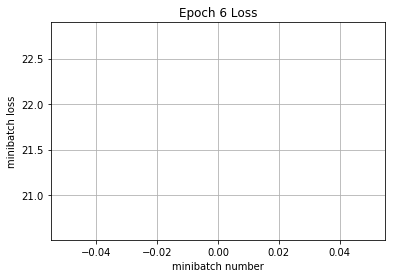

Iteration 3800: with minibatch training loss = 0.335 and accuracy of 0.98
Epoch 7, Overall loss = 0.000437 and accuracy of 0.00129


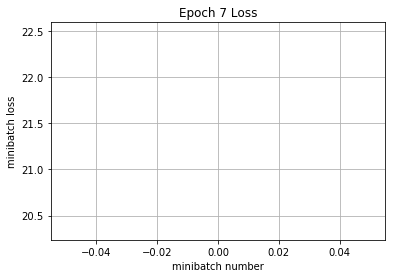

Iteration 3800: with minibatch training loss = 0.327 and accuracy of 0.98
Epoch 8, Overall loss = 0.000427 and accuracy of 0.00129


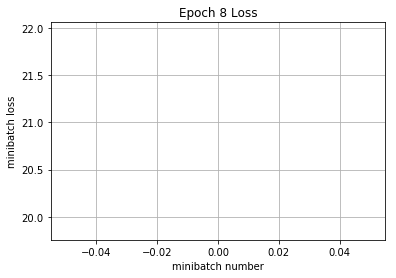

Iteration 3800: with minibatch training loss = 0.317 and accuracy of 0.98
Epoch 9, Overall loss = 0.000413 and accuracy of 0.00129


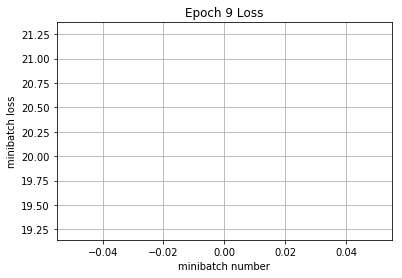

Iteration 3800: with minibatch training loss = 0.305 and accuracy of 0.98
Epoch 10, Overall loss = 0.000399 and accuracy of 0.00129


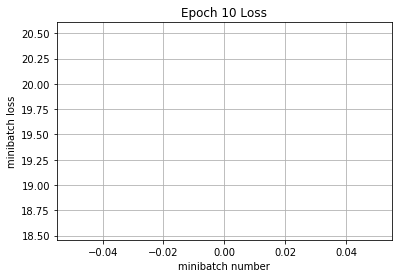

Validation
Epoch 1, Overall loss = 0.862 and accuracy of 0.774
Training
Iteration 0: with minibatch training loss = 3.65 and accuracy of 0.016
Iteration 100: with minibatch training loss = 2.29 and accuracy of 0.48
Iteration 200: with minibatch training loss = 2.02 and accuracy of 0.53
Iteration 300: with minibatch training loss = 1.76 and accuracy of 0.56
Iteration 400: with minibatch training loss = 1.58 and accuracy of 0.58
Iteration 500: with minibatch training loss = 1.4 and accuracy of 0.7
Iteration 600: with minibatch training loss = 1.65 and accuracy of 0.61
Iteration 700: with minibatch training loss = 1.07 and accuracy of 0.86
Epoch 1, Overall loss = 1.78 and accuracy of 0.592


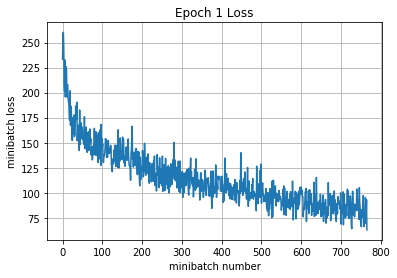

Iteration 800: with minibatch training loss = 1.41 and accuracy of 0.56
Iteration 900: with minibatch training loss = 0.9 and accuracy of 0.83
Iteration 1000: with minibatch training loss = 1.11 and accuracy of 0.7
Iteration 1100: with minibatch training loss = 0.954 and accuracy of 0.73
Iteration 1200: with minibatch training loss = 0.992 and accuracy of 0.8
Iteration 1300: with minibatch training loss = 1.03 and accuracy of 0.72
Iteration 1400: with minibatch training loss = 0.927 and accuracy of 0.7
Iteration 1500: with minibatch training loss = 0.757 and accuracy of 0.84
Epoch 2, Overall loss = 1.05 and accuracy of 0.744


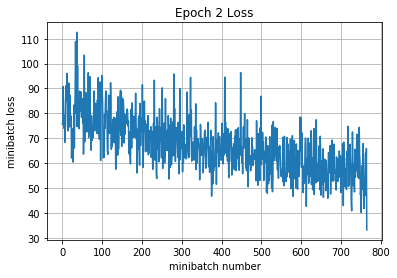

Iteration 1600: with minibatch training loss = 0.851 and accuracy of 0.8
Iteration 1700: with minibatch training loss = 0.844 and accuracy of 0.78
Iteration 1800: with minibatch training loss = 0.564 and accuracy of 0.89
Iteration 1900: with minibatch training loss = 0.611 and accuracy of 0.88
Iteration 2000: with minibatch training loss = 0.781 and accuracy of 0.78
Iteration 2100: with minibatch training loss = 0.719 and accuracy of 0.86
Iteration 2200: with minibatch training loss = 0.611 and accuracy of 0.89
Epoch 3, Overall loss = 0.72 and accuracy of 0.847


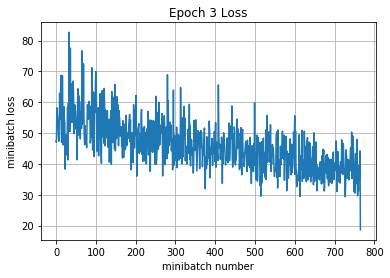

Iteration 2300: with minibatch training loss = 0.595 and accuracy of 0.89
Iteration 2400: with minibatch training loss = 0.589 and accuracy of 0.92
Iteration 2500: with minibatch training loss = 0.57 and accuracy of 0.86
Iteration 2600: with minibatch training loss = 0.439 and accuracy of 0.97
Iteration 2700: with minibatch training loss = 0.454 and accuracy of 0.97
Iteration 2800: with minibatch training loss = 0.407 and accuracy of 0.98
Epoch 4, Overall loss = 0.347 and accuracy of 0.602


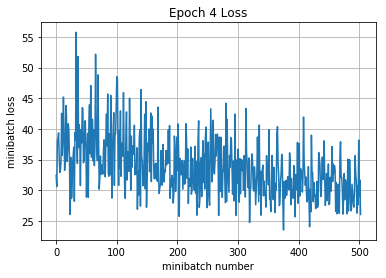

Iteration 2800: with minibatch training loss = 0.404 and accuracy of 0.95
Iteration 2900: with minibatch training loss = 0.56 and accuracy of 0.91
Iteration 3000: with minibatch training loss = 0.389 and accuracy of 0.98
Epoch 5, Overall loss = 0.112 and accuracy of 0.251


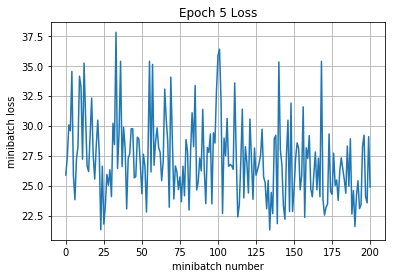

Iteration 3000: with minibatch training loss = 0.35 and accuracy of 0.98
Epoch 6, Overall loss = 0.000457 and accuracy of 0.00129


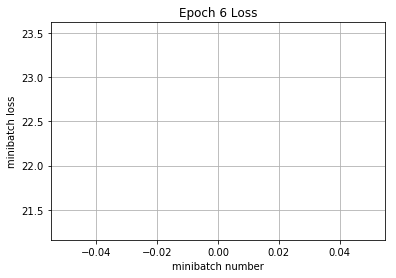

Iteration 3000: with minibatch training loss = 0.342 and accuracy of 0.98
Epoch 7, Overall loss = 0.000447 and accuracy of 0.00129


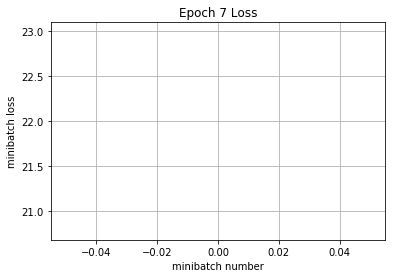

Iteration 3000: with minibatch training loss = 0.329 and accuracy of 1
Epoch 8, Overall loss = 0.000429 and accuracy of 0.00131


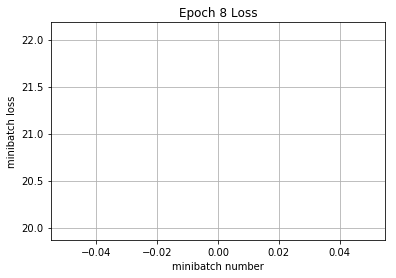

Iteration 3000: with minibatch training loss = 0.312 and accuracy of 1
Epoch 9, Overall loss = 0.000408 and accuracy of 0.00131


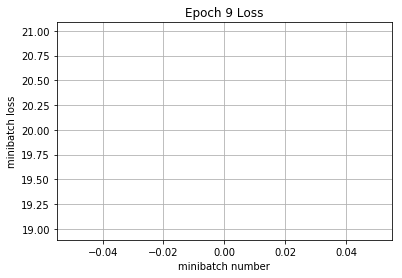

Iteration 3000: with minibatch training loss = 0.296 and accuracy of 1
Epoch 10, Overall loss = 0.000386 and accuracy of 0.00131


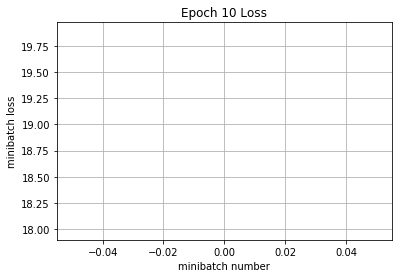

Validation
Epoch 1, Overall loss = 0.901 and accuracy of 0.779
Training
Iteration 0: with minibatch training loss = 3.57 and accuracy of 0.078
Iteration 100: with minibatch training loss = 2.36 and accuracy of 0.48
Iteration 200: with minibatch training loss = 2.28 and accuracy of 0.52
Iteration 300: with minibatch training loss = 1.8 and accuracy of 0.56
Iteration 400: with minibatch training loss = 1.7 and accuracy of 0.66
Iteration 500: with minibatch training loss = 1.44 and accuracy of 0.64
Iteration 600: with minibatch training loss = 1.27 and accuracy of 0.66
Iteration 700: with minibatch training loss = 1.39 and accuracy of 0.64
Epoch 1, Overall loss = 1.78 and accuracy of 0.585


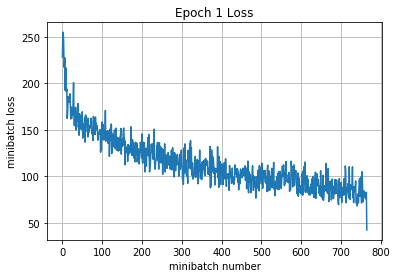

Iteration 800: with minibatch training loss = 1.19 and accuracy of 0.78
Iteration 900: with minibatch training loss = 1.38 and accuracy of 0.64
Iteration 1000: with minibatch training loss = 0.944 and accuracy of 0.77
Iteration 1100: with minibatch training loss = 1.16 and accuracy of 0.75
Iteration 1200: with minibatch training loss = 1.17 and accuracy of 0.66
Iteration 1300: with minibatch training loss = 0.766 and accuracy of 0.8
Iteration 1400: with minibatch training loss = 0.939 and accuracy of 0.77
Iteration 1500: with minibatch training loss = 0.85 and accuracy of 0.77
Epoch 2, Overall loss = 1.05 and accuracy of 0.739


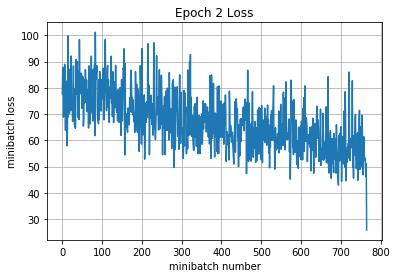

Iteration 1600: with minibatch training loss = 0.987 and accuracy of 0.77
Iteration 1700: with minibatch training loss = 0.722 and accuracy of 0.84
Iteration 1800: with minibatch training loss = 0.589 and accuracy of 0.92
Iteration 1900: with minibatch training loss = 0.704 and accuracy of 0.86
Iteration 2000: with minibatch training loss = 0.658 and accuracy of 0.84
Iteration 2100: with minibatch training loss = 0.703 and accuracy of 0.78
Iteration 2200: with minibatch training loss = 0.853 and accuracy of 0.83
Epoch 3, Overall loss = 0.72 and accuracy of 0.843


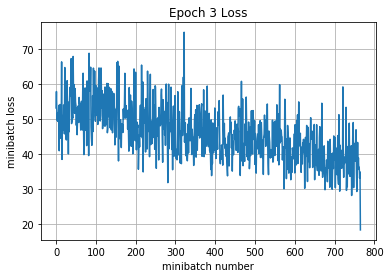

Iteration 2300: with minibatch training loss = 0.543 and accuracy of 0.91
Iteration 2400: with minibatch training loss = 0.634 and accuracy of 0.88
Iteration 2500: with minibatch training loss = 0.441 and accuracy of 0.98
Epoch 4, Overall loss = 0.149 and accuracy of 0.239


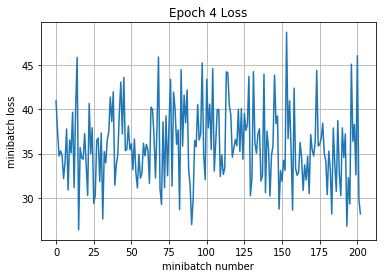

Iteration 2500: with minibatch training loss = 0.439 and accuracy of 0.95
Iteration 2600: with minibatch training loss = 0.457 and accuracy of 0.94
Iteration 2700: with minibatch training loss = 0.507 and accuracy of 0.92
Iteration 2800: with minibatch training loss = 0.411 and accuracy of 0.98
Epoch 5, Overall loss = 0.175 and accuracy of 0.372


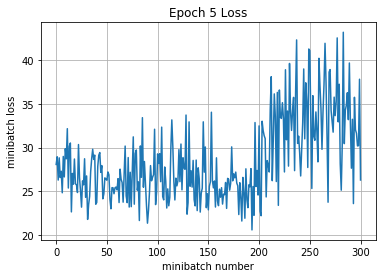

Iteration 2800: with minibatch training loss = 0.39 and accuracy of 0.97
Iteration 2900: with minibatch training loss = 0.375 and accuracy of 0.98
Epoch 6, Overall loss = 0.0465 and accuracy of 0.13


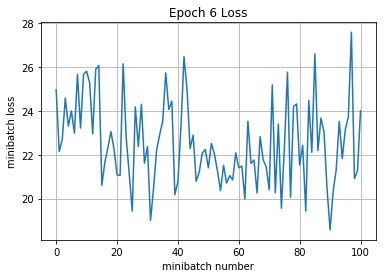

Iteration 2900: with minibatch training loss = 0.309 and accuracy of 1
Epoch 7, Overall loss = 0.000403 and accuracy of 0.00131


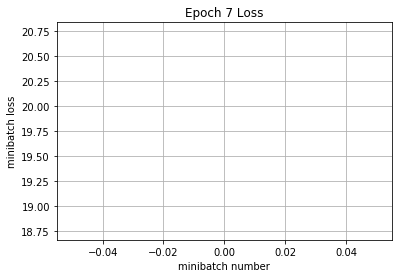

Iteration 2900: with minibatch training loss = 0.304 and accuracy of 1
Epoch 8, Overall loss = 0.000397 and accuracy of 0.00131


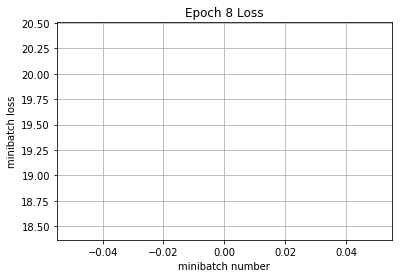

Iteration 2900: with minibatch training loss = 0.296 and accuracy of 1
Epoch 9, Overall loss = 0.000386 and accuracy of 0.00131


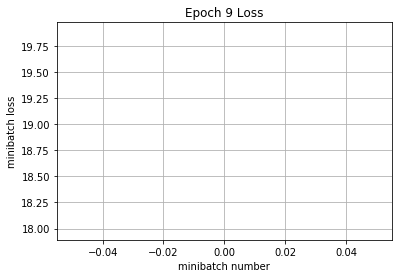

Iteration 2900: with minibatch training loss = 0.287 and accuracy of 1
Epoch 10, Overall loss = 0.000374 and accuracy of 0.00131


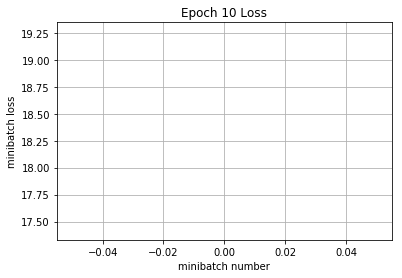

Validation
Epoch 1, Overall loss = 0.943 and accuracy of 0.746
Training
Iteration 0: with minibatch training loss = 3.44 and accuracy of 0.12
Iteration 100: with minibatch training loss = 2.23 and accuracy of 0.5
Iteration 200: with minibatch training loss = 1.79 and accuracy of 0.56
Iteration 300: with minibatch training loss = 1.63 and accuracy of 0.62
Iteration 400: with minibatch training loss = 1.7 and accuracy of 0.61
Iteration 500: with minibatch training loss = 1.6 and accuracy of 0.61
Iteration 600: with minibatch training loss = 1.24 and accuracy of 0.69
Iteration 700: with minibatch training loss = 1.48 and accuracy of 0.61
Epoch 1, Overall loss = 1.79 and accuracy of 0.578


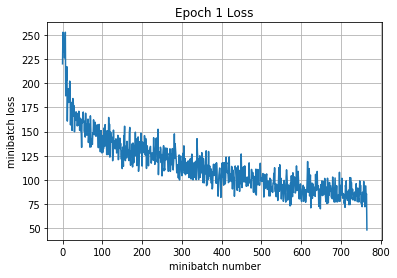

Iteration 800: with minibatch training loss = 1.42 and accuracy of 0.7
Iteration 900: with minibatch training loss = 1.11 and accuracy of 0.7
Iteration 1000: with minibatch training loss = 1.14 and accuracy of 0.77
Iteration 1100: with minibatch training loss = 1.08 and accuracy of 0.73
Iteration 1200: with minibatch training loss = 1.07 and accuracy of 0.75
Iteration 1300: with minibatch training loss = 0.907 and accuracy of 0.72
Iteration 1400: with minibatch training loss = 1.04 and accuracy of 0.72
Iteration 1500: with minibatch training loss = 1.03 and accuracy of 0.7
Epoch 2, Overall loss = 1.06 and accuracy of 0.731


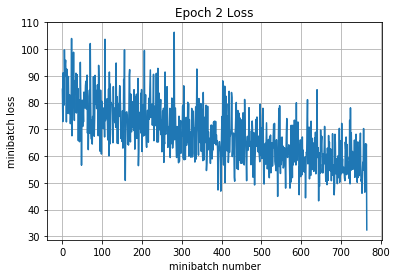

Iteration 1600: with minibatch training loss = 0.887 and accuracy of 0.77
Iteration 1700: with minibatch training loss = 0.998 and accuracy of 0.67
Iteration 1800: with minibatch training loss = 0.742 and accuracy of 0.78
Iteration 1900: with minibatch training loss = 0.705 and accuracy of 0.86
Iteration 2000: with minibatch training loss = 0.72 and accuracy of 0.81
Iteration 2100: with minibatch training loss = 0.646 and accuracy of 0.88
Iteration 2200: with minibatch training loss = 0.525 and accuracy of 0.91
Epoch 3, Overall loss = 0.736 and accuracy of 0.834


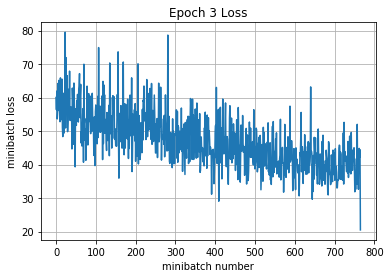

Iteration 2300: with minibatch training loss = 0.699 and accuracy of 0.83
Iteration 2400: with minibatch training loss = 0.536 and accuracy of 0.92
Iteration 2500: with minibatch training loss = 0.628 and accuracy of 0.84
Iteration 2600: with minibatch training loss = 0.539 and accuracy of 0.94
Iteration 2700: with minibatch training loss = 0.436 and accuracy of 0.94
Iteration 2800: with minibatch training loss = 0.416 and accuracy of 0.97
Iteration 2900: with minibatch training loss = 0.407 and accuracy of 0.95
Iteration 3000: with minibatch training loss = 0.467 and accuracy of 0.94
Epoch 4, Overall loss = 0.518 and accuracy of 0.913


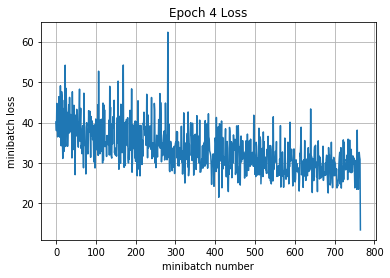

Iteration 3100: with minibatch training loss = 0.446 and accuracy of 0.95
Iteration 3200: with minibatch training loss = 0.489 and accuracy of 0.92
Iteration 3300: with minibatch training loss = 0.447 and accuracy of 0.94
Iteration 3400: with minibatch training loss = 0.431 and accuracy of 0.92
Iteration 3500: with minibatch training loss = 0.481 and accuracy of 0.91
Iteration 3600: with minibatch training loss = 0.353 and accuracy of 0.95
Iteration 3700: with minibatch training loss = 0.402 and accuracy of 0.94
Iteration 3800: with minibatch training loss = 0.383 and accuracy of 0.97
Epoch 5, Overall loss = 0.402 and accuracy of 0.956


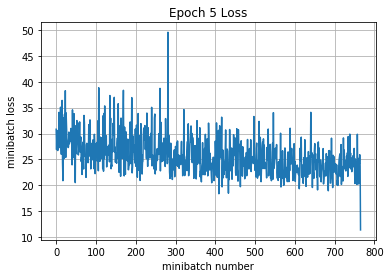

Iteration 3900: with minibatch training loss = 0.424 and accuracy of 0.94
Iteration 4000: with minibatch training loss = 0.328 and accuracy of 0.97
Iteration 4100: with minibatch training loss = 0.36 and accuracy of 0.98
Epoch 6, Overall loss = 0.129 and accuracy of 0.343


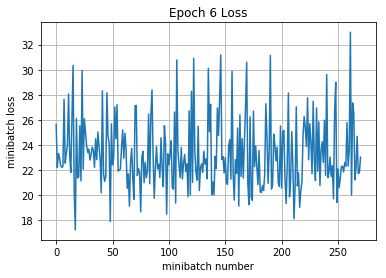

Iteration 4100: with minibatch training loss = 0.347 and accuracy of 0.95
Iteration 4200: with minibatch training loss = 0.315 and accuracy of 0.98
Epoch 7, Overall loss = 0.0436 and accuracy of 0.129


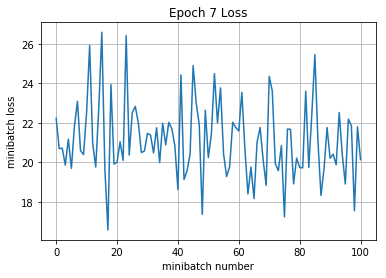

Iteration 4200: with minibatch training loss = 0.318 and accuracy of 0.95
Iteration 4300: with minibatch training loss = 0.297 and accuracy of 0.98
Epoch 8, Overall loss = 0.0403 and accuracy of 0.131


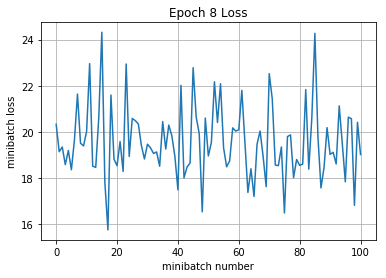

Iteration 4300: with minibatch training loss = 0.299 and accuracy of 0.95
Iteration 4400: with minibatch training loss = 0.285 and accuracy of 1
Epoch 9, Overall loss = 0.0384 and accuracy of 0.131


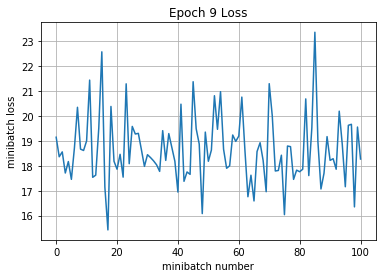

Iteration 4400: with minibatch training loss = 0.285 and accuracy of 0.97
Iteration 4500: with minibatch training loss = 0.276 and accuracy of 1
Epoch 10, Overall loss = 0.0371 and accuracy of 0.131


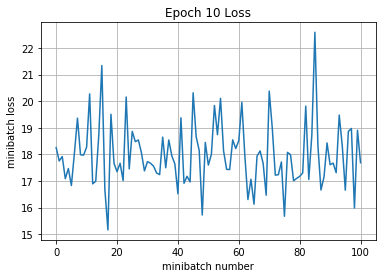

Validation
Epoch 1, Overall loss = 0.877 and accuracy of 0.761
Training
Iteration 0: with minibatch training loss = 3.49 and accuracy of 0.14
Iteration 100: with minibatch training loss = 2.45 and accuracy of 0.44
Iteration 200: with minibatch training loss = 2.18 and accuracy of 0.53
Iteration 300: with minibatch training loss = 1.74 and accuracy of 0.52
Iteration 400: with minibatch training loss = 1.6 and accuracy of 0.56
Iteration 500: with minibatch training loss = 1.57 and accuracy of 0.62
Iteration 600: with minibatch training loss = 1.37 and accuracy of 0.66
Iteration 700: with minibatch training loss = 1.32 and accuracy of 0.66
Epoch 1, Overall loss = 1.79 and accuracy of 0.574


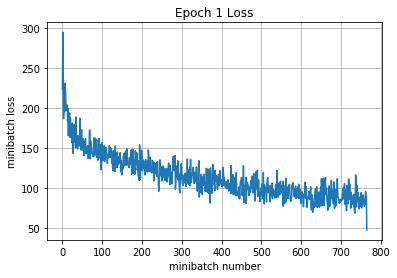

Iteration 800: with minibatch training loss = 1.3 and accuracy of 0.66
Iteration 900: with minibatch training loss = 1.09 and accuracy of 0.72
Iteration 1000: with minibatch training loss = 1.16 and accuracy of 0.72
Iteration 1100: with minibatch training loss = 1.27 and accuracy of 0.66
Iteration 1200: with minibatch training loss = 0.931 and accuracy of 0.77
Iteration 1300: with minibatch training loss = 0.925 and accuracy of 0.77
Iteration 1400: with minibatch training loss = 1.05 and accuracy of 0.72
Iteration 1500: with minibatch training loss = 0.777 and accuracy of 0.78
Epoch 2, Overall loss = 1.08 and accuracy of 0.721


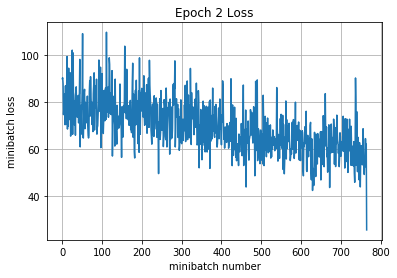

Iteration 1600: with minibatch training loss = 0.832 and accuracy of 0.83
Iteration 1700: with minibatch training loss = 0.759 and accuracy of 0.78
Iteration 1800: with minibatch training loss = 0.89 and accuracy of 0.73
Iteration 1900: with minibatch training loss = 0.673 and accuracy of 0.89
Iteration 2000: with minibatch training loss = 0.636 and accuracy of 0.84
Iteration 2100: with minibatch training loss = 0.733 and accuracy of 0.86
Iteration 2200: with minibatch training loss = 0.738 and accuracy of 0.78
Epoch 3, Overall loss = 0.76 and accuracy of 0.823


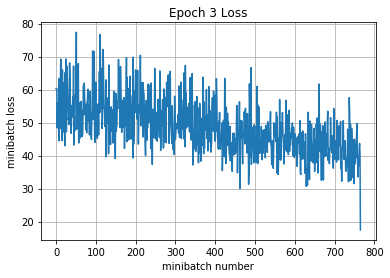

Iteration 2300: with minibatch training loss = 0.683 and accuracy of 0.84
Iteration 2400: with minibatch training loss = 0.572 and accuracy of 0.89
Iteration 2500: with minibatch training loss = 0.673 and accuracy of 0.83
Iteration 2600: with minibatch training loss = 0.523 and accuracy of 0.91
Iteration 2700: with minibatch training loss = 0.541 and accuracy of 0.89
Iteration 2800: with minibatch training loss = 0.451 and accuracy of 0.97
Iteration 2900: with minibatch training loss = 0.457 and accuracy of 0.91
Iteration 3000: with minibatch training loss = 0.447 and accuracy of 0.94
Epoch 4, Overall loss = 0.537 and accuracy of 0.904


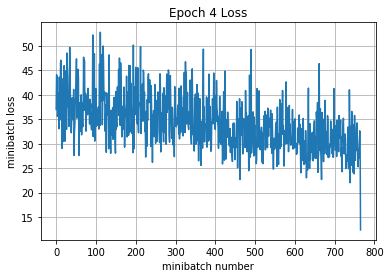

Iteration 3100: with minibatch training loss = 0.466 and accuracy of 0.92
Iteration 3200: with minibatch training loss = 0.362 and accuracy of 0.98
Epoch 5, Overall loss = 0.0794 and accuracy of 0.168


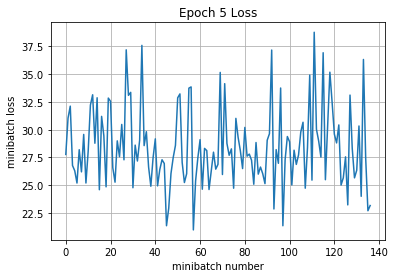

Iteration 3200: with minibatch training loss = 0.356 and accuracy of 0.95
Iteration 3300: with minibatch training loss = 0.344 and accuracy of 0.98
Epoch 6, Overall loss = 0.0476 and accuracy of 0.128


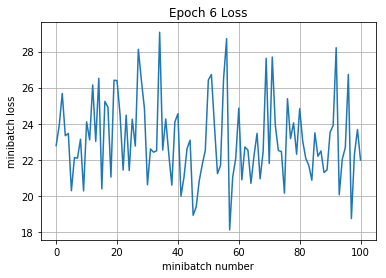

Iteration 3300: with minibatch training loss = 0.317 and accuracy of 1
Epoch 7, Overall loss = 0.000415 and accuracy of 0.00131


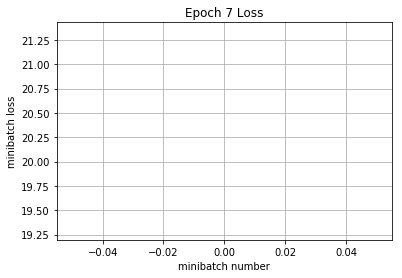

Iteration 3300: with minibatch training loss = 0.313 and accuracy of 1
Epoch 8, Overall loss = 0.000409 and accuracy of 0.00131


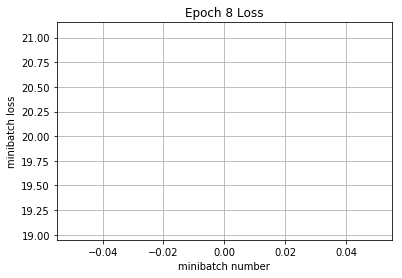

Iteration 3300: with minibatch training loss = 0.306 and accuracy of 1
Epoch 9, Overall loss = 0.0004 and accuracy of 0.00131


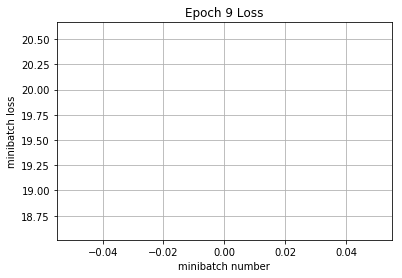

Iteration 3300: with minibatch training loss = 0.297 and accuracy of 1
Epoch 10, Overall loss = 0.000388 and accuracy of 0.00131


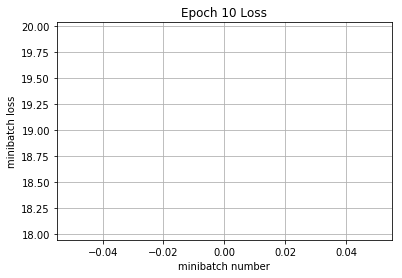

Validation
Epoch 1, Overall loss = 0.939 and accuracy of 0.74
Training
Iteration 0: with minibatch training loss = 3.45 and accuracy of 0.11
Iteration 100: with minibatch training loss = 2.25 and accuracy of 0.56
Iteration 200: with minibatch training loss = 2.05 and accuracy of 0.5
Iteration 300: with minibatch training loss = 2.22 and accuracy of 0.45
Iteration 400: with minibatch training loss = 2.01 and accuracy of 0.5
Iteration 500: with minibatch training loss = 1.73 and accuracy of 0.53
Iteration 600: with minibatch training loss = 1.62 and accuracy of 0.56
Iteration 700: with minibatch training loss = 1.26 and accuracy of 0.69
Epoch 1, Overall loss = 1.79 and accuracy of 0.582


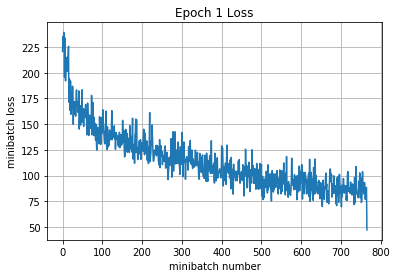

Iteration 800: with minibatch training loss = 1.34 and accuracy of 0.62
Iteration 900: with minibatch training loss = 1.08 and accuracy of 0.77
Iteration 1000: with minibatch training loss = 1.26 and accuracy of 0.67
Iteration 1100: with minibatch training loss = 1.32 and accuracy of 0.64
Iteration 1200: with minibatch training loss = 0.989 and accuracy of 0.72
Iteration 1300: with minibatch training loss = 0.905 and accuracy of 0.8
Iteration 1400: with minibatch training loss = 0.943 and accuracy of 0.67
Iteration 1500: with minibatch training loss = 0.98 and accuracy of 0.77
Epoch 2, Overall loss = 1.06 and accuracy of 0.734


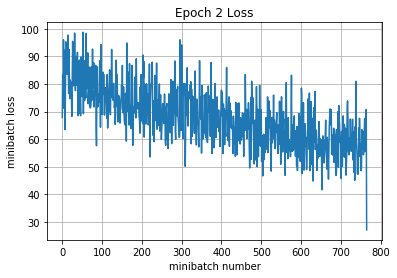

Iteration 1600: with minibatch training loss = 1.03 and accuracy of 0.69
Iteration 1700: with minibatch training loss = 0.788 and accuracy of 0.83
Iteration 1800: with minibatch training loss = 0.818 and accuracy of 0.78
Iteration 1900: with minibatch training loss = 0.845 and accuracy of 0.8
Iteration 2000: with minibatch training loss = 0.779 and accuracy of 0.83
Iteration 2100: with minibatch training loss = 0.825 and accuracy of 0.8
Iteration 2200: with minibatch training loss = 0.688 and accuracy of 0.89
Epoch 3, Overall loss = 0.732 and accuracy of 0.838


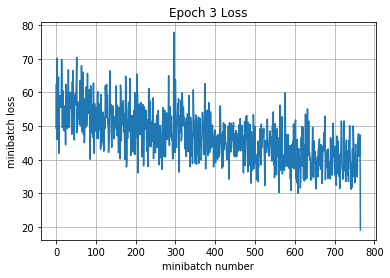

Iteration 2300: with minibatch training loss = 0.537 and accuracy of 0.88
Iteration 2400: with minibatch training loss = 0.671 and accuracy of 0.84
Iteration 2500: with minibatch training loss = 0.541 and accuracy of 0.92
Iteration 2600: with minibatch training loss = 0.453 and accuracy of 0.95
Iteration 2700: with minibatch training loss = 0.5 and accuracy of 0.94
Iteration 2800: with minibatch training loss = 0.43 and accuracy of 0.95
Iteration 2900: with minibatch training loss = 0.566 and accuracy of 0.89
Iteration 3000: with minibatch training loss = 0.499 and accuracy of 0.91
Epoch 4, Overall loss = 0.514 and accuracy of 0.916


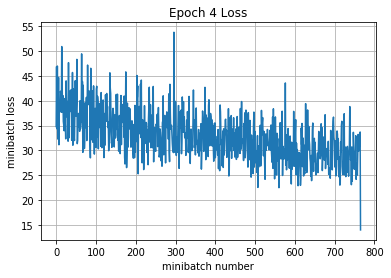

Iteration 3100: with minibatch training loss = 0.444 and accuracy of 0.98
Epoch 5, Overall loss = 0.0214 and accuracy of 0.0457


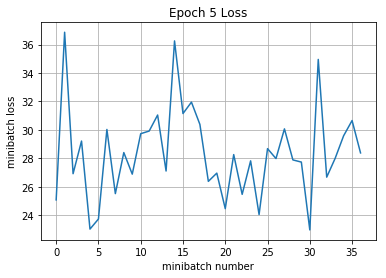

Iteration 3100: with minibatch training loss = 0.322 and accuracy of 1
Epoch 6, Overall loss = 0.00042 and accuracy of 0.00131


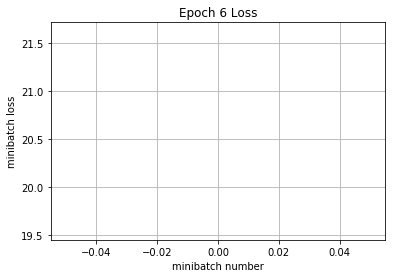

Iteration 3100: with minibatch training loss = 0.318 and accuracy of 1
Epoch 7, Overall loss = 0.000415 and accuracy of 0.00131


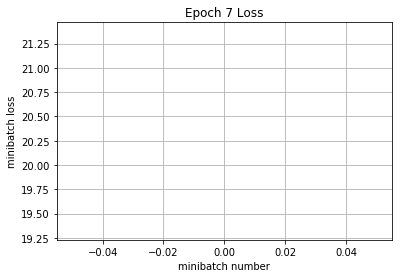

Iteration 3100: with minibatch training loss = 0.311 and accuracy of 1
Epoch 8, Overall loss = 0.000406 and accuracy of 0.00131


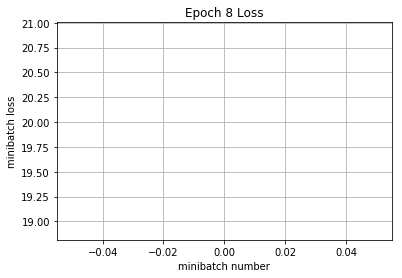

Iteration 3100: with minibatch training loss = 0.302 and accuracy of 1
Epoch 9, Overall loss = 0.000395 and accuracy of 0.00131


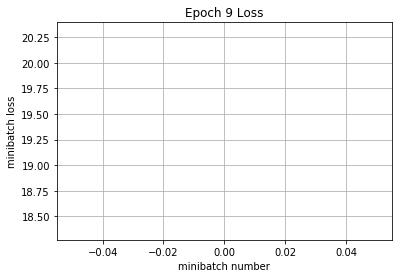

Iteration 3100: with minibatch training loss = 0.292 and accuracy of 1
Epoch 10, Overall loss = 0.000381 and accuracy of 0.00131


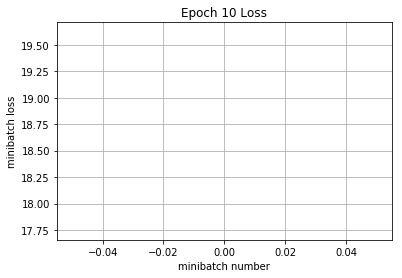

Validation
Epoch 1, Overall loss = 0.944 and accuracy of 0.748
Training
Iteration 0: with minibatch training loss = 3.59 and accuracy of 0.094
Iteration 100: with minibatch training loss = 2.35 and accuracy of 0.55
Iteration 200: with minibatch training loss = 2 and accuracy of 0.59
Iteration 300: with minibatch training loss = 2.11 and accuracy of 0.59
Iteration 400: with minibatch training loss = 1.92 and accuracy of 0.56
Iteration 500: with minibatch training loss = 1.64 and accuracy of 0.61
Iteration 600: with minibatch training loss = 1.49 and accuracy of 0.67
Iteration 700: with minibatch training loss = 1.42 and accuracy of 0.64
Epoch 1, Overall loss = 1.79 and accuracy of 0.583


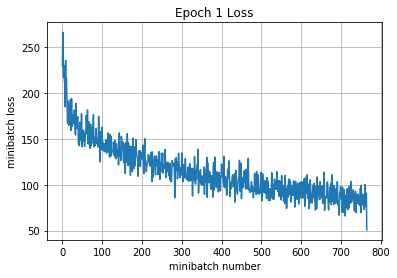

Iteration 800: with minibatch training loss = 1.5 and accuracy of 0.61
Iteration 900: with minibatch training loss = 1.35 and accuracy of 0.67
Iteration 1000: with minibatch training loss = 1.08 and accuracy of 0.66
Iteration 1100: with minibatch training loss = 0.845 and accuracy of 0.78
Iteration 1200: with minibatch training loss = 0.751 and accuracy of 0.81
Iteration 1300: with minibatch training loss = 1.14 and accuracy of 0.72
Iteration 1400: with minibatch training loss = 0.859 and accuracy of 0.81
Iteration 1500: with minibatch training loss = 0.732 and accuracy of 0.81
Epoch 2, Overall loss = 1.06 and accuracy of 0.734


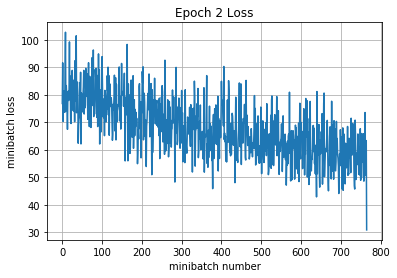

Iteration 1600: with minibatch training loss = 0.671 and accuracy of 0.88
Iteration 1700: with minibatch training loss = 0.824 and accuracy of 0.83
Iteration 1800: with minibatch training loss = 0.663 and accuracy of 0.88
Iteration 1900: with minibatch training loss = 0.652 and accuracy of 0.91
Iteration 2000: with minibatch training loss = 0.681 and accuracy of 0.84
Iteration 2100: with minibatch training loss = 0.687 and accuracy of 0.86
Iteration 2200: with minibatch training loss = 0.563 and accuracy of 0.91
Epoch 3, Overall loss = 0.732 and accuracy of 0.838


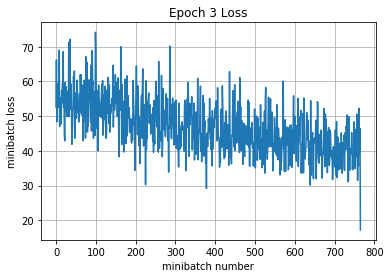

Iteration 2300: with minibatch training loss = 0.56 and accuracy of 0.88
Iteration 2400: with minibatch training loss = 0.505 and accuracy of 0.92
Iteration 2500: with minibatch training loss = 0.69 and accuracy of 0.86
Iteration 2600: with minibatch training loss = 0.585 and accuracy of 0.86
Iteration 2700: with minibatch training loss = 0.629 and accuracy of 0.86
Iteration 2800: with minibatch training loss = 0.486 and accuracy of 0.89
Iteration 2900: with minibatch training loss = 0.452 and accuracy of 0.95
Iteration 3000: with minibatch training loss = 0.492 and accuracy of 0.91
Epoch 4, Overall loss = 0.516 and accuracy of 0.917


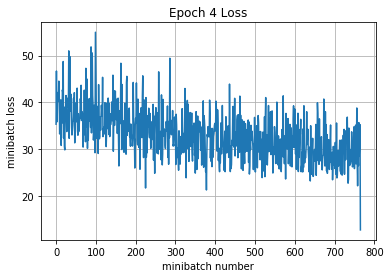

Iteration 3100: with minibatch training loss = 0.413 and accuracy of 0.97
Iteration 3200: with minibatch training loss = 0.443 and accuracy of 0.91
Iteration 3300: with minibatch training loss = 0.41 and accuracy of 0.95
Iteration 3400: with minibatch training loss = 0.381 and accuracy of 0.97
Iteration 3500: with minibatch training loss = 0.499 and accuracy of 0.89
Iteration 3600: with minibatch training loss = 0.369 and accuracy of 0.97
Iteration 3700: with minibatch training loss = 0.343 and accuracy of 0.98
Epoch 5, Overall loss = 0.337 and accuracy of 0.795


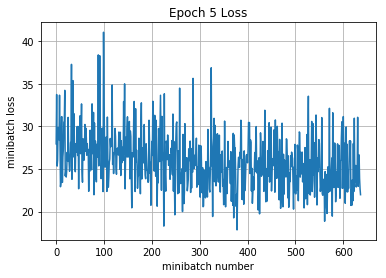

Iteration 3700: with minibatch training loss = 0.393 and accuracy of 0.95
Iteration 3800: with minibatch training loss = 0.415 and accuracy of 0.94
Iteration 3900: with minibatch training loss = 0.385 and accuracy of 0.97
Iteration 4000: with minibatch training loss = 0.349 and accuracy of 0.97
Iteration 4100: with minibatch training loss = 0.349 and accuracy of 0.95
Iteration 4200: with minibatch training loss = 0.307 and accuracy of 0.97
Iteration 4300: with minibatch training loss = 0.428 and accuracy of 0.94
Iteration 4400: with minibatch training loss = 0.39 and accuracy of 0.95
Epoch 6, Overall loss = 0.355 and accuracy of 0.972


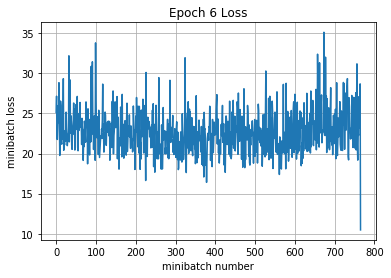

Iteration 4500: with minibatch training loss = 0.339 and accuracy of 1
Epoch 7, Overall loss = 0.0149 and accuracy of 0.0449


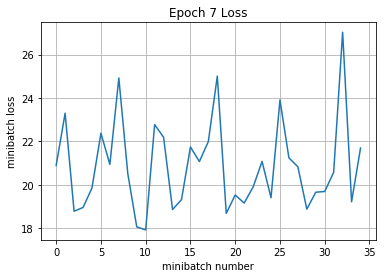

Iteration 4500: with minibatch training loss = 0.311 and accuracy of 1
Epoch 8, Overall loss = 0.000406 and accuracy of 0.00131


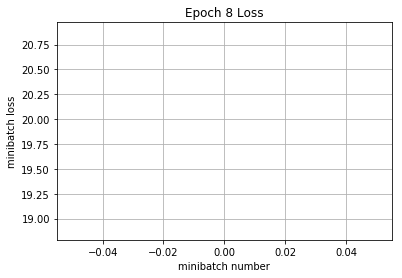

Iteration 4500: with minibatch training loss = 0.309 and accuracy of 1
Epoch 9, Overall loss = 0.000404 and accuracy of 0.00131


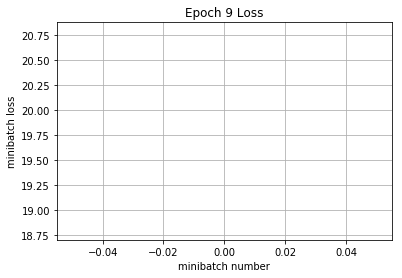

Iteration 4500: with minibatch training loss = 0.306 and accuracy of 1
Epoch 10, Overall loss = 0.0004 and accuracy of 0.00131


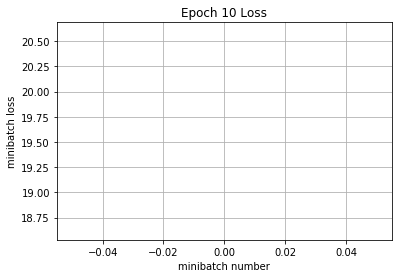

Validation
Epoch 1, Overall loss = 0.859 and accuracy of 0.767
Training
Iteration 0: with minibatch training loss = 3.63 and accuracy of 0.078
Iteration 100: with minibatch training loss = 2.18 and accuracy of 0.56
Iteration 200: with minibatch training loss = 1.73 and accuracy of 0.69
Iteration 300: with minibatch training loss = 1.92 and accuracy of 0.53
Iteration 400: with minibatch training loss = 1.85 and accuracy of 0.59
Iteration 500: with minibatch training loss = 1.25 and accuracy of 0.72
Iteration 600: with minibatch training loss = 1.48 and accuracy of 0.67
Iteration 700: with minibatch training loss = 1.54 and accuracy of 0.62
Epoch 1, Overall loss = 1.8 and accuracy of 0.581


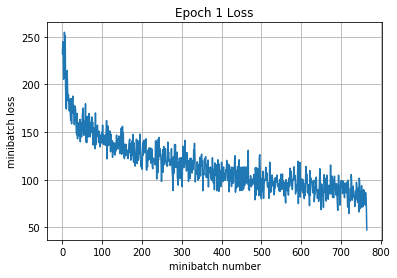

Iteration 800: with minibatch training loss = 1.31 and accuracy of 0.69
Iteration 900: with minibatch training loss = 1.13 and accuracy of 0.7
Iteration 1000: with minibatch training loss = 1.22 and accuracy of 0.66
Iteration 1100: with minibatch training loss = 0.944 and accuracy of 0.75
Iteration 1200: with minibatch training loss = 1.25 and accuracy of 0.69
Iteration 1300: with minibatch training loss = 1.14 and accuracy of 0.75
Iteration 1400: with minibatch training loss = 0.913 and accuracy of 0.8
Iteration 1500: with minibatch training loss = 0.868 and accuracy of 0.77
Epoch 2, Overall loss = 1.08 and accuracy of 0.73


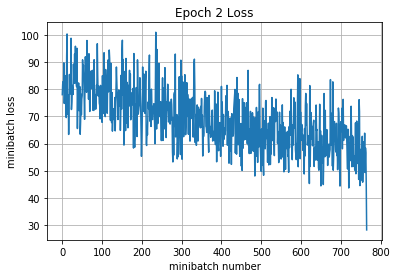

Iteration 1600: with minibatch training loss = 0.875 and accuracy of 0.78
Iteration 1700: with minibatch training loss = 0.758 and accuracy of 0.77
Iteration 1800: with minibatch training loss = 0.643 and accuracy of 0.88
Iteration 1900: with minibatch training loss = 0.629 and accuracy of 0.91
Iteration 2000: with minibatch training loss = 0.665 and accuracy of 0.86
Iteration 2100: with minibatch training loss = 0.595 and accuracy of 0.91
Iteration 2200: with minibatch training loss = 0.618 and accuracy of 0.81
Epoch 3, Overall loss = 0.742 and accuracy of 0.833


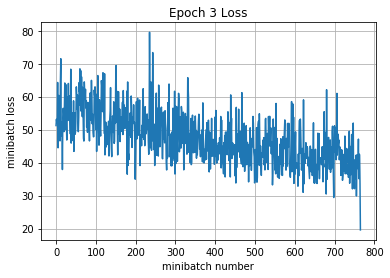

Iteration 2300: with minibatch training loss = 0.553 and accuracy of 0.94
Iteration 2400: with minibatch training loss = 0.49 and accuracy of 0.97
Iteration 2500: with minibatch training loss = 0.567 and accuracy of 0.92
Iteration 2600: with minibatch training loss = 0.489 and accuracy of 0.95
Iteration 2700: with minibatch training loss = 0.64 and accuracy of 0.84
Iteration 2800: with minibatch training loss = 0.397 and accuracy of 0.97
Iteration 2900: with minibatch training loss = 0.555 and accuracy of 0.91
Iteration 3000: with minibatch training loss = 0.527 and accuracy of 0.89
Epoch 4, Overall loss = 0.519 and accuracy of 0.916


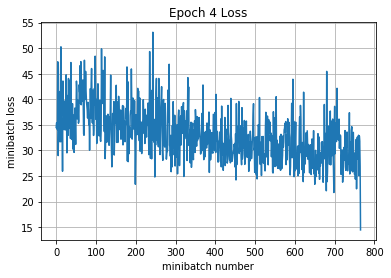

Iteration 3100: with minibatch training loss = 0.381 and accuracy of 0.98
Epoch 5, Overall loss = 0.0208 and accuracy of 0.046


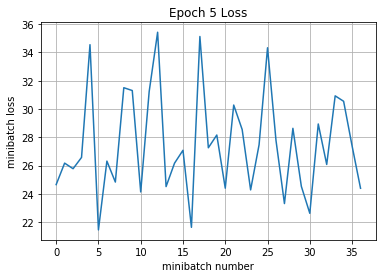

Iteration 3100: with minibatch training loss = 0.324 and accuracy of 0.98
Epoch 6, Overall loss = 0.000423 and accuracy of 0.00129


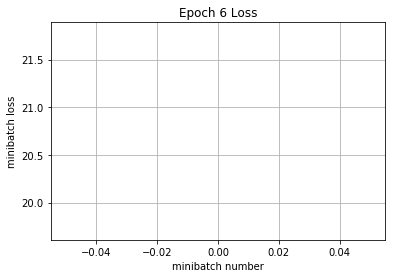

Iteration 3100: with minibatch training loss = 0.32 and accuracy of 0.98
Epoch 7, Overall loss = 0.000418 and accuracy of 0.00129


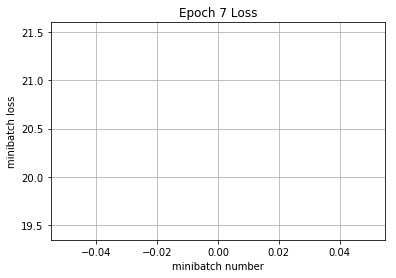

Iteration 3100: with minibatch training loss = 0.312 and accuracy of 0.98
Epoch 8, Overall loss = 0.000408 and accuracy of 0.00129


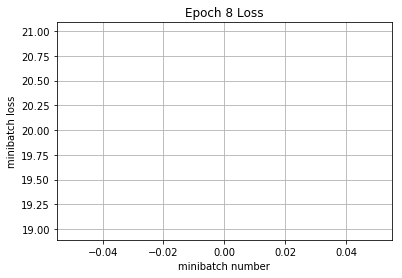

Iteration 3100: with minibatch training loss = 0.303 and accuracy of 0.98
Epoch 9, Overall loss = 0.000395 and accuracy of 0.00129


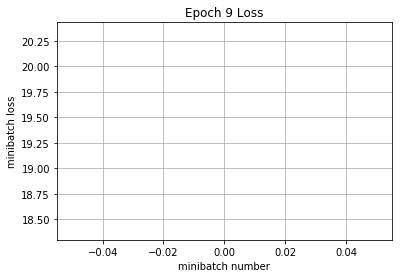

Iteration 3100: with minibatch training loss = 0.292 and accuracy of 0.98
Epoch 10, Overall loss = 0.000381 and accuracy of 0.00129


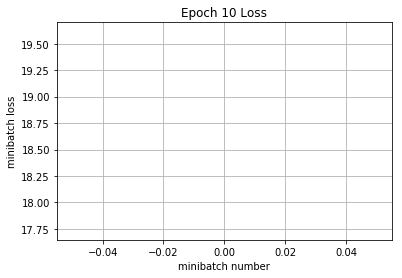

Validation
Epoch 1, Overall loss = 0.936 and accuracy of 0.756
Training
Iteration 0: with minibatch training loss = 3.41 and accuracy of 0.078
Iteration 100: with minibatch training loss = 1.98 and accuracy of 0.56
Iteration 200: with minibatch training loss = 1.87 and accuracy of 0.62
Iteration 300: with minibatch training loss = 1.76 and accuracy of 0.61
Iteration 400: with minibatch training loss = 1.69 and accuracy of 0.56
Iteration 500: with minibatch training loss = 1.28 and accuracy of 0.78
Iteration 600: with minibatch training loss = 1.39 and accuracy of 0.67
Iteration 700: with minibatch training loss = 1.4 and accuracy of 0.69
Epoch 1, Overall loss = 1.79 and accuracy of 0.584


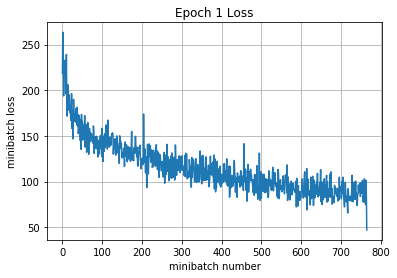

Iteration 800: with minibatch training loss = 1.42 and accuracy of 0.61
Iteration 900: with minibatch training loss = 1.11 and accuracy of 0.67
Iteration 1000: with minibatch training loss = 0.958 and accuracy of 0.77
Iteration 1100: with minibatch training loss = 1.15 and accuracy of 0.7
Iteration 1200: with minibatch training loss = 1.02 and accuracy of 0.7
Iteration 1300: with minibatch training loss = 1.16 and accuracy of 0.7
Iteration 1400: with minibatch training loss = 0.984 and accuracy of 0.78
Iteration 1500: with minibatch training loss = 0.832 and accuracy of 0.78
Epoch 2, Overall loss = 1.07 and accuracy of 0.732


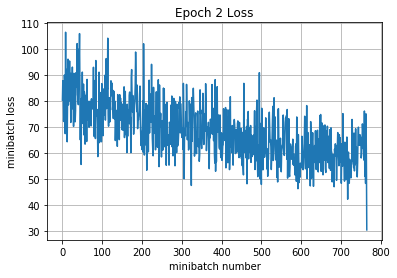

Iteration 1600: with minibatch training loss = 0.778 and accuracy of 0.84
Iteration 1700: with minibatch training loss = 0.947 and accuracy of 0.77
Iteration 1800: with minibatch training loss = 0.595 and accuracy of 0.86
Iteration 1900: with minibatch training loss = 0.673 and accuracy of 0.88
Iteration 2000: with minibatch training loss = 0.635 and accuracy of 0.89
Iteration 2100: with minibatch training loss = 0.617 and accuracy of 0.88
Iteration 2200: with minibatch training loss = 0.666 and accuracy of 0.84
Epoch 3, Overall loss = 0.736 and accuracy of 0.837


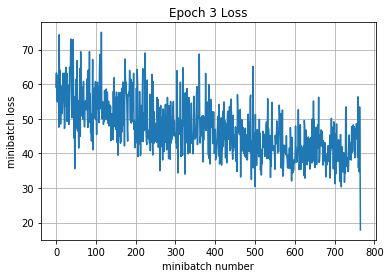

Iteration 2300: with minibatch training loss = 0.599 and accuracy of 0.86
Iteration 2400: with minibatch training loss = 0.493 and accuracy of 0.94
Iteration 2500: with minibatch training loss = 0.665 and accuracy of 0.81
Iteration 2600: with minibatch training loss = 0.499 and accuracy of 0.94
Iteration 2700: with minibatch training loss = 0.412 and accuracy of 0.97
Iteration 2800: with minibatch training loss = 0.459 and accuracy of 0.95
Iteration 2900: with minibatch training loss = 0.484 and accuracy of 0.91
Iteration 3000: with minibatch training loss = 0.535 and accuracy of 0.84
Epoch 4, Overall loss = 0.517 and accuracy of 0.917


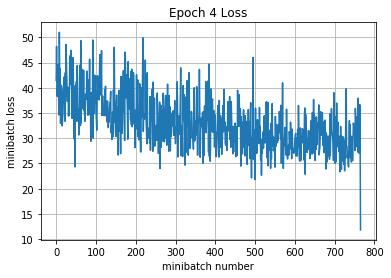

Iteration 3100: with minibatch training loss = 0.472 and accuracy of 0.98
Epoch 5, Overall loss = 0.0222 and accuracy of 0.0452


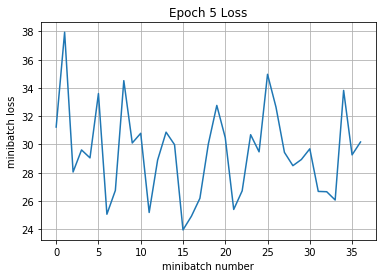

Iteration 3100: with minibatch training loss = 0.373 and accuracy of 0.97
Iteration 3200: with minibatch training loss = 0.402 and accuracy of 0.92
Iteration 3300: with minibatch training loss = 0.403 and accuracy of 0.95
Iteration 3400: with minibatch training loss = 0.337 and accuracy of 1
Epoch 6, Overall loss = 0.163 and accuracy of 0.375


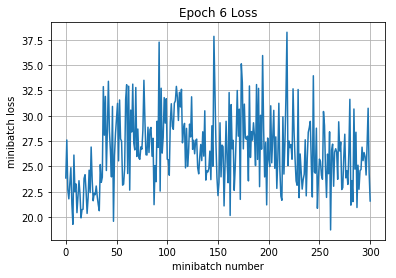

Iteration 3400: with minibatch training loss = 0.385 and accuracy of 0.94
Iteration 3500: with minibatch training loss = 0.339 and accuracy of 0.97
Iteration 3600: with minibatch training loss = 0.341 and accuracy of 0.98
Epoch 7, Overall loss = 0.0942 and accuracy of 0.256


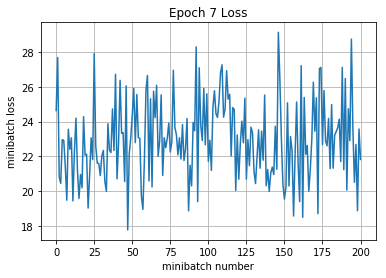

Iteration 3600: with minibatch training loss = 0.341 and accuracy of 0.98
Epoch 8, Overall loss = 0.000445 and accuracy of 0.00129


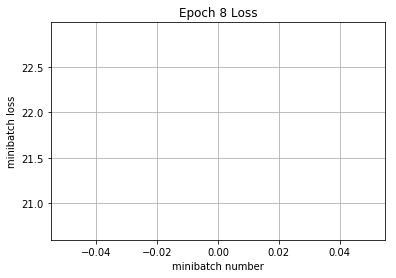

Iteration 3600: with minibatch training loss = 0.335 and accuracy of 0.98
Epoch 9, Overall loss = 0.000438 and accuracy of 0.00129


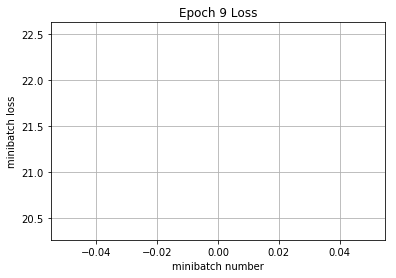

Iteration 3600: with minibatch training loss = 0.326 and accuracy of 0.98
Epoch 10, Overall loss = 0.000426 and accuracy of 0.00129


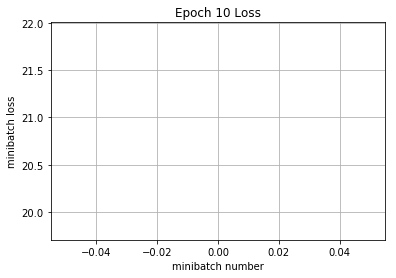

Validation
Epoch 1, Overall loss = 0.922 and accuracy of 0.758
Training
Iteration 0: with minibatch training loss = 3.61 and accuracy of 0.11
Iteration 100: with minibatch training loss = 2.31 and accuracy of 0.45
Iteration 200: with minibatch training loss = 2.03 and accuracy of 0.53
Iteration 300: with minibatch training loss = 1.95 and accuracy of 0.5
Iteration 400: with minibatch training loss = 1.74 and accuracy of 0.55
Iteration 500: with minibatch training loss = 1.53 and accuracy of 0.53
Iteration 600: with minibatch training loss = 1.59 and accuracy of 0.66
Iteration 700: with minibatch training loss = 1.37 and accuracy of 0.64
Epoch 1, Overall loss = 1.8 and accuracy of 0.579


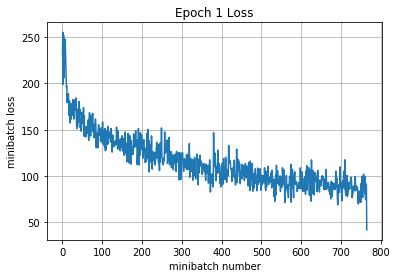

Iteration 800: with minibatch training loss = 1.29 and accuracy of 0.64
Iteration 900: with minibatch training loss = 1.12 and accuracy of 0.73
Iteration 1000: with minibatch training loss = 0.988 and accuracy of 0.72
Iteration 1100: with minibatch training loss = 1.06 and accuracy of 0.69
Iteration 1200: with minibatch training loss = 0.913 and accuracy of 0.78
Iteration 1300: with minibatch training loss = 0.711 and accuracy of 0.84
Iteration 1400: with minibatch training loss = 1.11 and accuracy of 0.7
Iteration 1500: with minibatch training loss = 0.935 and accuracy of 0.78
Epoch 2, Overall loss = 1.08 and accuracy of 0.728


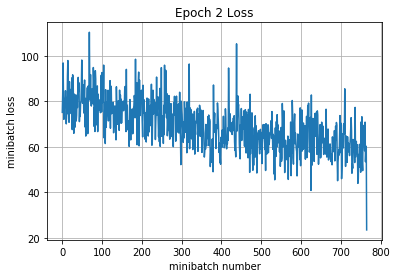

Iteration 1600: with minibatch training loss = 1.25 and accuracy of 0.62
Iteration 1700: with minibatch training loss = 0.661 and accuracy of 0.88
Iteration 1800: with minibatch training loss = 1.01 and accuracy of 0.81
Iteration 1900: with minibatch training loss = 0.776 and accuracy of 0.81
Iteration 2000: with minibatch training loss = 0.92 and accuracy of 0.83
Iteration 2100: with minibatch training loss = 0.53 and accuracy of 0.92
Iteration 2200: with minibatch training loss = 0.736 and accuracy of 0.81
Epoch 3, Overall loss = 0.746 and accuracy of 0.834


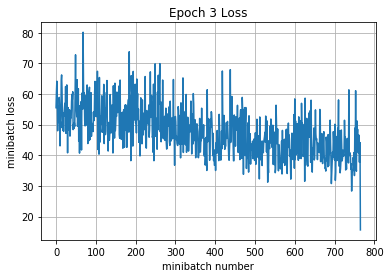

Iteration 2300: with minibatch training loss = 0.622 and accuracy of 0.95
Iteration 2400: with minibatch training loss = 0.557 and accuracy of 0.89
Iteration 2500: with minibatch training loss = 0.546 and accuracy of 0.94
Iteration 2600: with minibatch training loss = 0.457 and accuracy of 0.95
Iteration 2700: with minibatch training loss = 0.524 and accuracy of 0.89
Iteration 2800: with minibatch training loss = 0.481 and accuracy of 0.94
Iteration 2900: with minibatch training loss = 0.548 and accuracy of 0.91
Iteration 3000: with minibatch training loss = 0.401 and accuracy of 0.94
Epoch 4, Overall loss = 0.521 and accuracy of 0.917


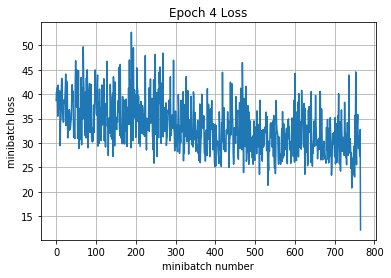

Iteration 3100: with minibatch training loss = 0.382 and accuracy of 0.97
Iteration 3200: with minibatch training loss = 0.46 and accuracy of 0.94
Iteration 3300: with minibatch training loss = 0.4 and accuracy of 0.94
Iteration 3400: with minibatch training loss = 0.341 and accuracy of 0.98
Epoch 5, Overall loss = 0.185 and accuracy of 0.419


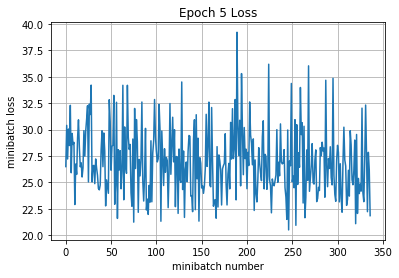

Iteration 3400: with minibatch training loss = 0.381 and accuracy of 0.98
Epoch 6, Overall loss = 0.000498 and accuracy of 0.00129


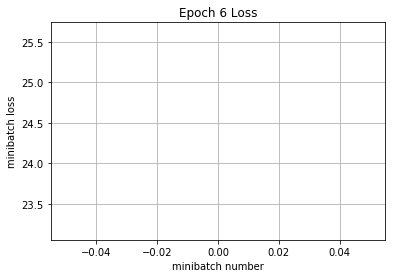

Iteration 3400: with minibatch training loss = 0.375 and accuracy of 0.98
Epoch 7, Overall loss = 0.00049 and accuracy of 0.00129


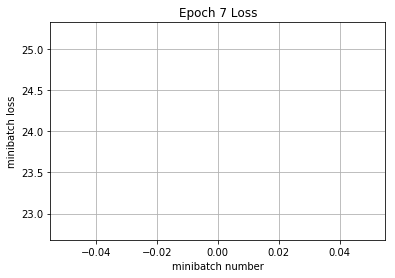

Iteration 3400: with minibatch training loss = 0.363 and accuracy of 0.98
Epoch 8, Overall loss = 0.000475 and accuracy of 0.00129


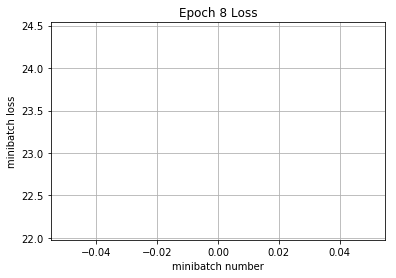

Iteration 3400: with minibatch training loss = 0.348 and accuracy of 0.98
Epoch 9, Overall loss = 0.000455 and accuracy of 0.00129


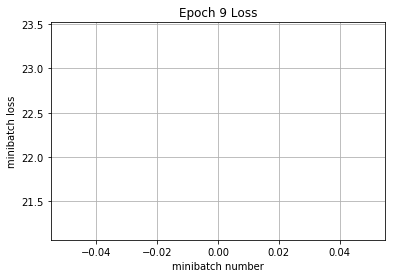

Iteration 3400: with minibatch training loss = 0.332 and accuracy of 1
Epoch 10, Overall loss = 0.000433 and accuracy of 0.00131


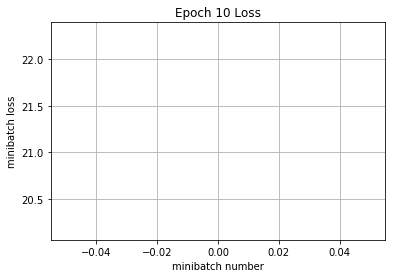

Validation
Epoch 1, Overall loss = 0.916 and accuracy of 0.754
Training
Iteration 0: with minibatch training loss = 3.79 and accuracy of 0.047
Iteration 100: with minibatch training loss = 2.19 and accuracy of 0.45
Iteration 200: with minibatch training loss = 2.14 and accuracy of 0.44
Iteration 300: with minibatch training loss = 1.71 and accuracy of 0.59
Iteration 400: with minibatch training loss = 1.61 and accuracy of 0.67
Iteration 500: with minibatch training loss = 1.4 and accuracy of 0.67
Iteration 600: with minibatch training loss = 1.67 and accuracy of 0.53
Iteration 700: with minibatch training loss = 1.06 and accuracy of 0.78
Epoch 1, Overall loss = 1.79 and accuracy of 0.581


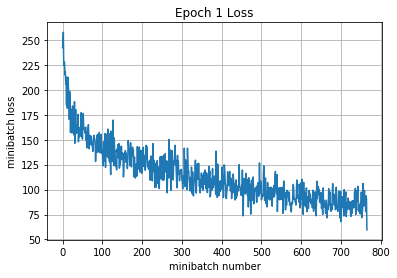

Iteration 800: with minibatch training loss = 1.09 and accuracy of 0.77
Iteration 900: with minibatch training loss = 1.04 and accuracy of 0.72
Iteration 1000: with minibatch training loss = 1.1 and accuracy of 0.72
Iteration 1100: with minibatch training loss = 1.21 and accuracy of 0.62
Iteration 1200: with minibatch training loss = 0.863 and accuracy of 0.78
Iteration 1300: with minibatch training loss = 1.21 and accuracy of 0.66
Iteration 1400: with minibatch training loss = 0.794 and accuracy of 0.86
Iteration 1500: with minibatch training loss = 1.01 and accuracy of 0.72
Epoch 2, Overall loss = 1.07 and accuracy of 0.733


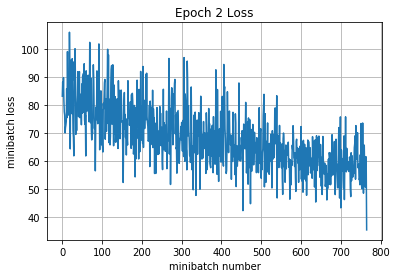

Iteration 1600: with minibatch training loss = 0.894 and accuracy of 0.78
Iteration 1700: with minibatch training loss = 0.794 and accuracy of 0.78
Iteration 1800: with minibatch training loss = 1.09 and accuracy of 0.67
Iteration 1900: with minibatch training loss = 0.841 and accuracy of 0.77
Iteration 2000: with minibatch training loss = 0.759 and accuracy of 0.81
Iteration 2100: with minibatch training loss = 0.72 and accuracy of 0.83
Iteration 2200: with minibatch training loss = 0.57 and accuracy of 0.84
Epoch 3, Overall loss = 0.735 and accuracy of 0.837


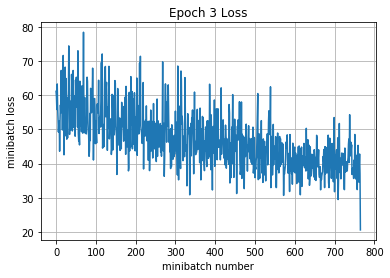

Iteration 2300: with minibatch training loss = 0.592 and accuracy of 0.91
Iteration 2400: with minibatch training loss = 0.501 and accuracy of 0.89
Iteration 2500: with minibatch training loss = 0.532 and accuracy of 0.94
Iteration 2600: with minibatch training loss = 0.502 and accuracy of 0.94
Iteration 2700: with minibatch training loss = 0.531 and accuracy of 0.91
Iteration 2800: with minibatch training loss = 0.403 and accuracy of 0.97
Iteration 2900: with minibatch training loss = 0.452 and accuracy of 0.94
Iteration 3000: with minibatch training loss = 0.466 and accuracy of 0.94
Epoch 4, Overall loss = 0.513 and accuracy of 0.918


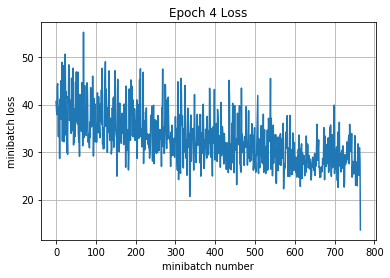

Iteration 3100: with minibatch training loss = 0.428 and accuracy of 0.95
Iteration 3200: with minibatch training loss = 0.415 and accuracy of 0.92
Iteration 3300: with minibatch training loss = 0.388 and accuracy of 0.97
Iteration 3400: with minibatch training loss = 0.279 and accuracy of 1
Epoch 5, Overall loss = 0.186 and accuracy of 0.418


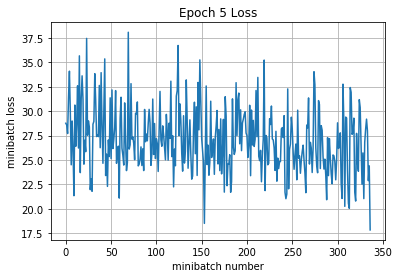

Iteration 3400: with minibatch training loss = 0.371 and accuracy of 1
Epoch 6, Overall loss = 0.000484 and accuracy of 0.00131


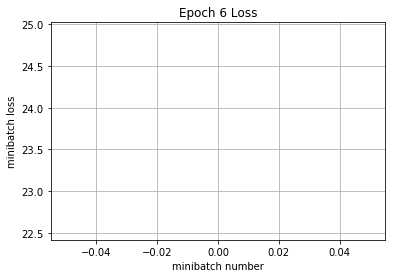

Iteration 3400: with minibatch training loss = 0.364 and accuracy of 1
Epoch 7, Overall loss = 0.000475 and accuracy of 0.00131


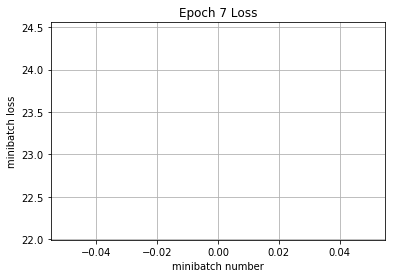

Iteration 3400: with minibatch training loss = 0.352 and accuracy of 1
Epoch 8, Overall loss = 0.000459 and accuracy of 0.00131


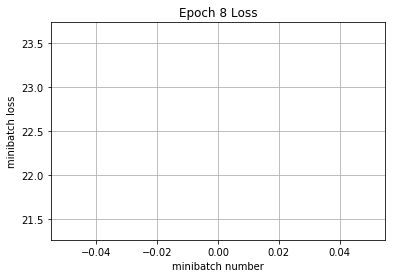

Iteration 3400: with minibatch training loss = 0.336 and accuracy of 1
Epoch 9, Overall loss = 0.000439 and accuracy of 0.00131


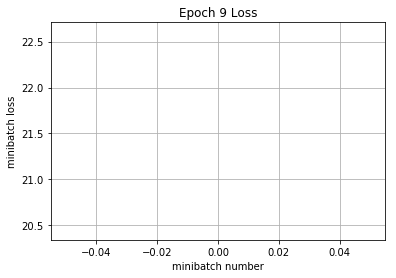

Iteration 3400: with minibatch training loss = 0.32 and accuracy of 1
Epoch 10, Overall loss = 0.000418 and accuracy of 0.00131


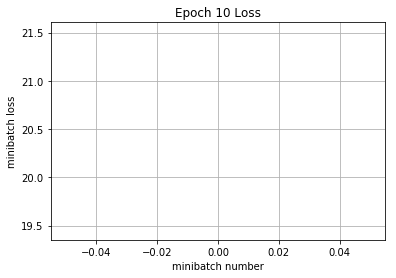

Validation
Epoch 1, Overall loss = 0.898 and accuracy of 0.758
Training
Iteration 0: with minibatch training loss = 3.42 and accuracy of 0.094
Iteration 100: with minibatch training loss = 2.45 and accuracy of 0.38
Iteration 200: with minibatch training loss = 1.77 and accuracy of 0.67
Iteration 300: with minibatch training loss = 1.85 and accuracy of 0.58
Iteration 400: with minibatch training loss = 1.67 and accuracy of 0.59
Iteration 500: with minibatch training loss = 1.62 and accuracy of 0.56
Iteration 600: with minibatch training loss = 1.36 and accuracy of 0.67
Iteration 700: with minibatch training loss = 1.71 and accuracy of 0.59
Epoch 1, Overall loss = 1.79 and accuracy of 0.586


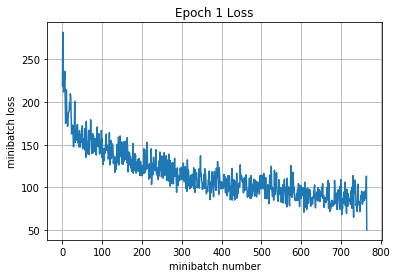

Iteration 800: with minibatch training loss = 1.25 and accuracy of 0.62
Iteration 900: with minibatch training loss = 1.24 and accuracy of 0.73
Iteration 1000: with minibatch training loss = 1.17 and accuracy of 0.69
Iteration 1100: with minibatch training loss = 1.13 and accuracy of 0.69
Iteration 1200: with minibatch training loss = 0.865 and accuracy of 0.83
Iteration 1300: with minibatch training loss = 0.844 and accuracy of 0.8
Iteration 1400: with minibatch training loss = 1.09 and accuracy of 0.7
Iteration 1500: with minibatch training loss = 1.03 and accuracy of 0.7
Epoch 2, Overall loss = 1.07 and accuracy of 0.737


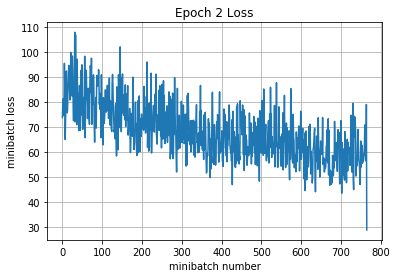

Iteration 1600: with minibatch training loss = 0.735 and accuracy of 0.84
Iteration 1700: with minibatch training loss = 0.735 and accuracy of 0.84
Iteration 1800: with minibatch training loss = 0.8 and accuracy of 0.8
Iteration 1900: with minibatch training loss = 0.761 and accuracy of 0.84
Iteration 2000: with minibatch training loss = 0.608 and accuracy of 0.94
Iteration 2100: with minibatch training loss = 0.671 and accuracy of 0.86
Iteration 2200: with minibatch training loss = 0.72 and accuracy of 0.84
Epoch 3, Overall loss = 0.731 and accuracy of 0.841


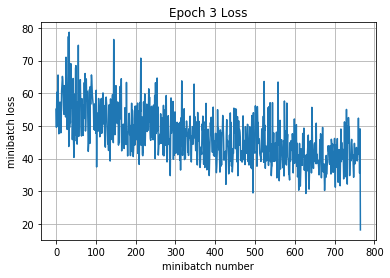

Iteration 2300: with minibatch training loss = 0.671 and accuracy of 0.86
Iteration 2400: with minibatch training loss = 0.413 and accuracy of 0.97
Iteration 2500: with minibatch training loss = 0.601 and accuracy of 0.84
Iteration 2600: with minibatch training loss = 0.562 and accuracy of 0.89
Iteration 2700: with minibatch training loss = 0.426 and accuracy of 0.98
Epoch 4, Overall loss = 0.287 and accuracy of 0.477


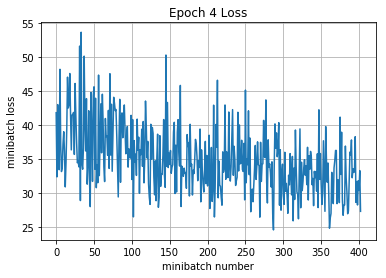

Iteration 2700: with minibatch training loss = 0.556 and accuracy of 0.89
Iteration 2800: with minibatch training loss = 0.354 and accuracy of 0.98
Epoch 5, Overall loss = 0.0606 and accuracy of 0.124


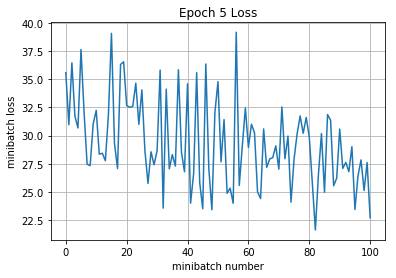

Iteration 2800: with minibatch training loss = 0.43 and accuracy of 0.95
Iteration 2900: with minibatch training loss = 0.31 and accuracy of 1
Epoch 6, Overall loss = 0.0473 and accuracy of 0.13


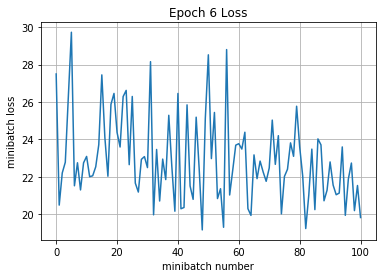

Iteration 2900: with minibatch training loss = 0.362 and accuracy of 0.97
Iteration 3000: with minibatch training loss = 0.286 and accuracy of 1
Epoch 7, Overall loss = 0.0415 and accuracy of 0.131


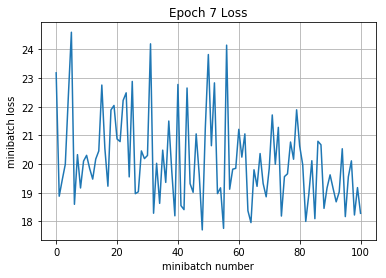

Iteration 3000: with minibatch training loss = 0.322 and accuracy of 0.97
Iteration 3100: with minibatch training loss = 0.269 and accuracy of 1
Epoch 8, Overall loss = 0.038 and accuracy of 0.131


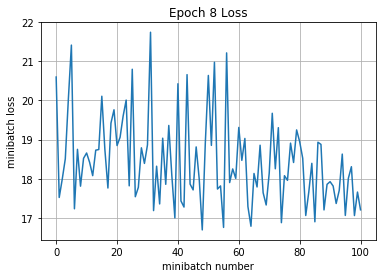

Iteration 3100: with minibatch training loss = 0.295 and accuracy of 1
Epoch 9, Overall loss = 0.000385 and accuracy of 0.00131


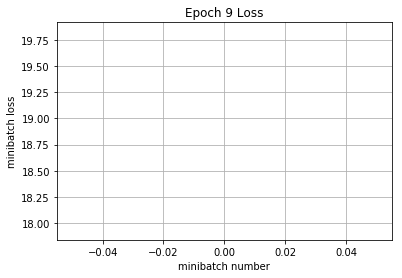

Iteration 3100: with minibatch training loss = 0.292 and accuracy of 1
Epoch 10, Overall loss = 0.000381 and accuracy of 0.00131


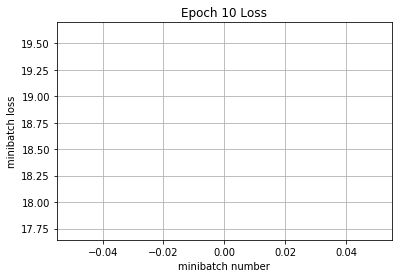

Validation
Epoch 1, Overall loss = 0.912 and accuracy of 0.76
Training
Iteration 0: with minibatch training loss = 3.73 and accuracy of 0.094
Iteration 100: with minibatch training loss = 2.61 and accuracy of 0.36
Iteration 200: with minibatch training loss = 2.14 and accuracy of 0.5
Iteration 300: with minibatch training loss = 1.62 and accuracy of 0.67
Iteration 400: with minibatch training loss = 1.66 and accuracy of 0.56
Iteration 500: with minibatch training loss = 1.44 and accuracy of 0.59
Iteration 600: with minibatch training loss = 1.44 and accuracy of 0.58
Iteration 700: with minibatch training loss = 1.34 and accuracy of 0.66
Epoch 1, Overall loss = 1.82 and accuracy of 0.58


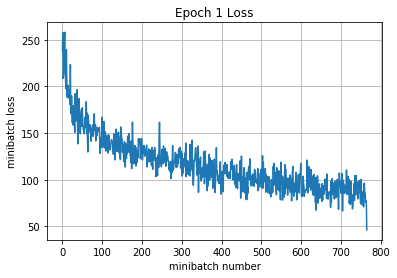

Iteration 800: with minibatch training loss = 1.14 and accuracy of 0.75
Iteration 900: with minibatch training loss = 1.25 and accuracy of 0.69
Iteration 1000: with minibatch training loss = 1.03 and accuracy of 0.7
Iteration 1100: with minibatch training loss = 1.22 and accuracy of 0.67
Iteration 1200: with minibatch training loss = 1.11 and accuracy of 0.7
Iteration 1300: with minibatch training loss = 0.948 and accuracy of 0.75
Iteration 1400: with minibatch training loss = 0.847 and accuracy of 0.78
Iteration 1500: with minibatch training loss = 0.843 and accuracy of 0.81
Epoch 2, Overall loss = 1.07 and accuracy of 0.737


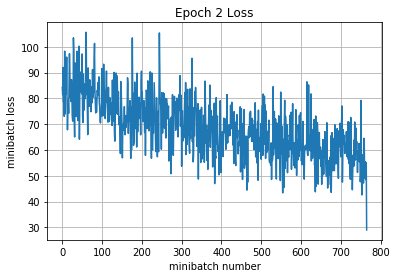

Iteration 1600: with minibatch training loss = 0.808 and accuracy of 0.8
Iteration 1700: with minibatch training loss = 0.821 and accuracy of 0.84
Iteration 1800: with minibatch training loss = 0.651 and accuracy of 0.92
Iteration 1900: with minibatch training loss = 0.87 and accuracy of 0.8
Iteration 2000: with minibatch training loss = 0.733 and accuracy of 0.84
Iteration 2100: with minibatch training loss = 0.661 and accuracy of 0.88
Iteration 2200: with minibatch training loss = 0.571 and accuracy of 0.86
Epoch 3, Overall loss = 0.736 and accuracy of 0.842


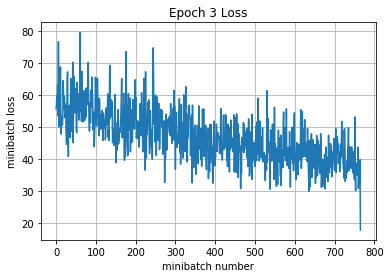

Iteration 2300: with minibatch training loss = 0.639 and accuracy of 0.88
Iteration 2400: with minibatch training loss = 0.516 and accuracy of 0.97
Iteration 2500: with minibatch training loss = 0.53 and accuracy of 0.91
Iteration 2600: with minibatch training loss = 0.572 and accuracy of 0.92
Iteration 2700: with minibatch training loss = 0.555 and accuracy of 0.91
Iteration 2800: with minibatch training loss = 0.456 and accuracy of 0.94
Iteration 2900: with minibatch training loss = 0.409 and accuracy of 0.95
Iteration 3000: with minibatch training loss = 0.521 and accuracy of 0.92
Epoch 4, Overall loss = 0.516 and accuracy of 0.924


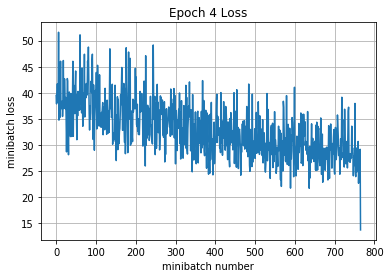

Iteration 3100: with minibatch training loss = 0.377 and accuracy of 0.98
Epoch 5, Overall loss = 0.0216 and accuracy of 0.0454


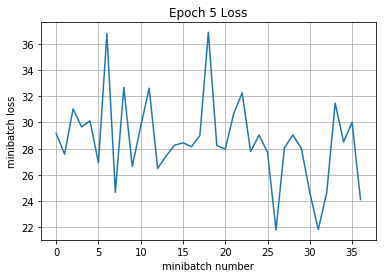

Iteration 3100: with minibatch training loss = 0.34 and accuracy of 0.98
Epoch 6, Overall loss = 0.000444 and accuracy of 0.00129


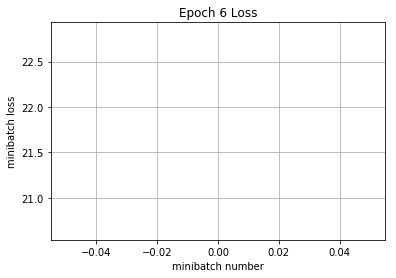

Iteration 3100: with minibatch training loss = 0.334 and accuracy of 1
Epoch 7, Overall loss = 0.000437 and accuracy of 0.00131


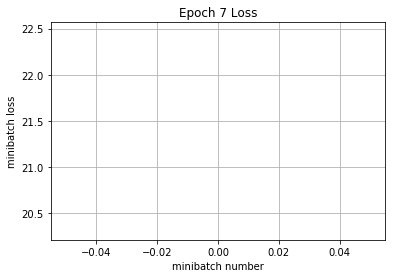

Iteration 3100: with minibatch training loss = 0.325 and accuracy of 1
Epoch 8, Overall loss = 0.000425 and accuracy of 0.00131


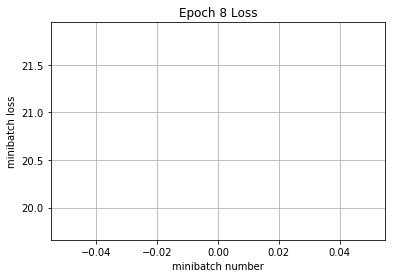

Iteration 3100: with minibatch training loss = 0.314 and accuracy of 1
Epoch 9, Overall loss = 0.00041 and accuracy of 0.00131


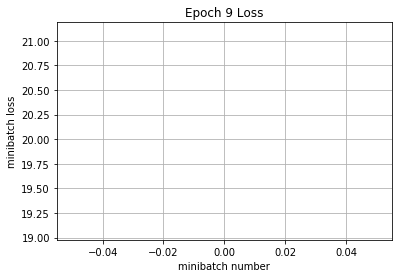

Iteration 3100: with minibatch training loss = 0.302 and accuracy of 1
Epoch 10, Overall loss = 0.000394 and accuracy of 0.00131


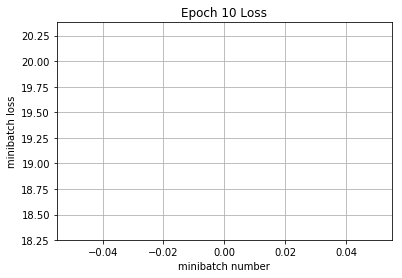

Validation
Epoch 1, Overall loss = 0.934 and accuracy of 0.758
Training
Iteration 0: with minibatch training loss = 3.41 and accuracy of 0.19
Iteration 100: with minibatch training loss = 1.86 and accuracy of 0.62
Iteration 200: with minibatch training loss = 1.76 and accuracy of 0.62
Iteration 300: with minibatch training loss = 1.75 and accuracy of 0.62
Iteration 400: with minibatch training loss = 1.69 and accuracy of 0.59
Iteration 500: with minibatch training loss = 1.58 and accuracy of 0.64
Iteration 600: with minibatch training loss = 1.22 and accuracy of 0.69
Iteration 700: with minibatch training loss = 1.6 and accuracy of 0.62
Epoch 1, Overall loss = 1.79 and accuracy of 0.585


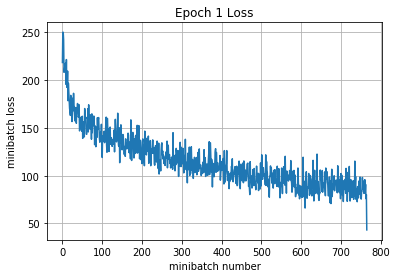

Iteration 800: with minibatch training loss = 1.09 and accuracy of 0.8
Iteration 900: with minibatch training loss = 1.19 and accuracy of 0.7
Iteration 1000: with minibatch training loss = 1.2 and accuracy of 0.67
Iteration 1100: with minibatch training loss = 1.04 and accuracy of 0.75
Iteration 1200: with minibatch training loss = 1.14 and accuracy of 0.66
Iteration 1300: with minibatch training loss = 1.07 and accuracy of 0.7
Iteration 1400: with minibatch training loss = 1.12 and accuracy of 0.75
Iteration 1500: with minibatch training loss = 0.885 and accuracy of 0.75
Epoch 2, Overall loss = 1.07 and accuracy of 0.734


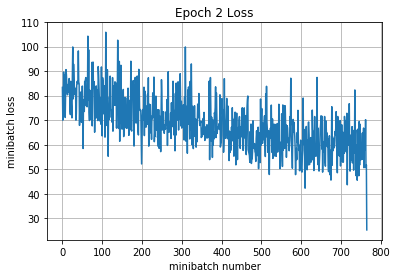

Iteration 1600: with minibatch training loss = 0.708 and accuracy of 0.86
Iteration 1700: with minibatch training loss = 0.824 and accuracy of 0.84
Iteration 1800: with minibatch training loss = 0.637 and accuracy of 0.88
Iteration 1900: with minibatch training loss = 0.666 and accuracy of 0.86
Iteration 2000: with minibatch training loss = 0.575 and accuracy of 0.89
Iteration 2100: with minibatch training loss = 0.742 and accuracy of 0.81
Iteration 2200: with minibatch training loss = 0.591 and accuracy of 0.89
Epoch 3, Overall loss = 0.739 and accuracy of 0.837


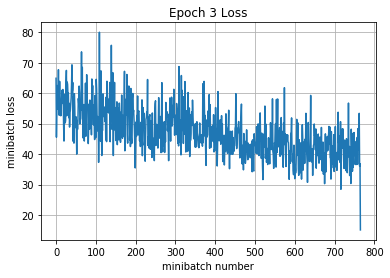

Iteration 2300: with minibatch training loss = 0.564 and accuracy of 0.91
Iteration 2400: with minibatch training loss = 0.707 and accuracy of 0.88
Iteration 2500: with minibatch training loss = 0.496 and accuracy of 0.94
Iteration 2600: with minibatch training loss = 0.525 and accuracy of 0.89
Iteration 2700: with minibatch training loss = 0.525 and accuracy of 0.92
Iteration 2800: with minibatch training loss = 0.466 and accuracy of 0.94
Iteration 2900: with minibatch training loss = 0.415 and accuracy of 0.94
Iteration 3000: with minibatch training loss = 0.539 and accuracy of 0.91
Epoch 4, Overall loss = 0.518 and accuracy of 0.92


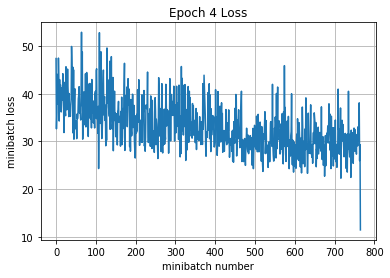

Iteration 3100: with minibatch training loss = 0.409 and accuracy of 0.97
Iteration 3200: with minibatch training loss = 0.376 and accuracy of 0.97
Iteration 3300: with minibatch training loss = 0.439 and accuracy of 0.92
Iteration 3400: with minibatch training loss = 0.386 and accuracy of 0.94
Iteration 3500: with minibatch training loss = 0.339 and accuracy of 0.97
Iteration 3600: with minibatch training loss = 0.381 and accuracy of 0.97
Iteration 3700: with minibatch training loss = 0.388 and accuracy of 0.97
Iteration 3800: with minibatch training loss = 0.37 and accuracy of 0.97
Epoch 5, Overall loss = 0.404 and accuracy of 0.959


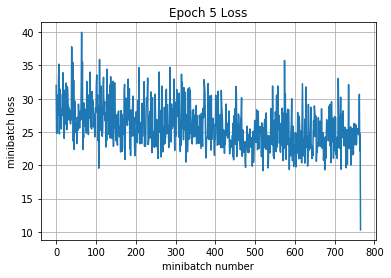

Iteration 3900: with minibatch training loss = 0.394 and accuracy of 0.95
Iteration 4000: with minibatch training loss = 0.336 and accuracy of 0.97
Iteration 4100: with minibatch training loss = 0.322 and accuracy of 0.95
Iteration 4200: with minibatch training loss = 0.378 and accuracy of 0.97
Iteration 4300: with minibatch training loss = 0.332 and accuracy of 0.95
Iteration 4400: with minibatch training loss = 0.292 and accuracy of 0.98
Epoch 6, Overall loss = 0.265 and accuracy of 0.726


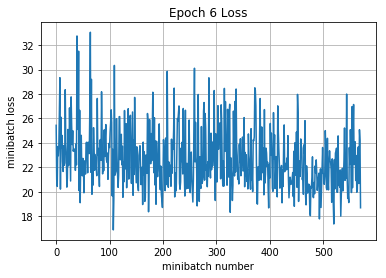

Iteration 4400: with minibatch training loss = 0.36 and accuracy of 0.97
Iteration 4500: with minibatch training loss = 0.337 and accuracy of 0.97
Iteration 4600: with minibatch training loss = 0.313 and accuracy of 0.97
Iteration 4700: with minibatch training loss = 0.335 and accuracy of 0.98
Epoch 7, Overall loss = 0.13 and accuracy of 0.386


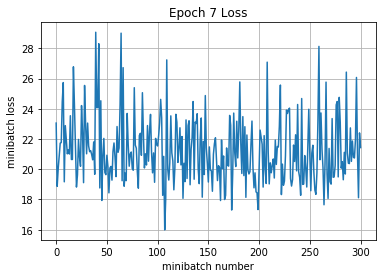

Iteration 4700: with minibatch training loss = 0.351 and accuracy of 0.98
Epoch 8, Overall loss = 0.000458 and accuracy of 0.00129


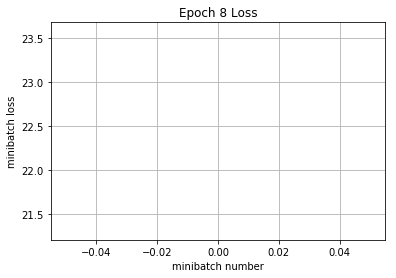

Iteration 4700: with minibatch training loss = 0.349 and accuracy of 0.98
Epoch 9, Overall loss = 0.000456 and accuracy of 0.00129


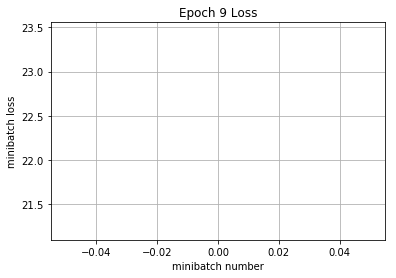

Iteration 4700: with minibatch training loss = 0.345 and accuracy of 0.98
Epoch 10, Overall loss = 0.000451 and accuracy of 0.00129


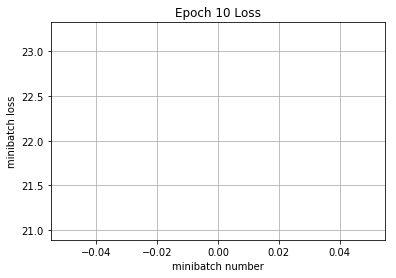

Validation
Epoch 1, Overall loss = 0.869 and accuracy of 0.761
Training
Iteration 0: with minibatch training loss = 3.7 and accuracy of 0.11
Iteration 100: with minibatch training loss = 2.37 and accuracy of 0.42
Iteration 200: with minibatch training loss = 1.86 and accuracy of 0.53
Iteration 300: with minibatch training loss = 1.71 and accuracy of 0.59
Iteration 400: with minibatch training loss = 1.63 and accuracy of 0.62
Iteration 500: with minibatch training loss = 1.51 and accuracy of 0.66
Iteration 600: with minibatch training loss = 1.14 and accuracy of 0.75
Iteration 700: with minibatch training loss = 1.58 and accuracy of 0.56
Epoch 1, Overall loss = 1.79 and accuracy of 0.585


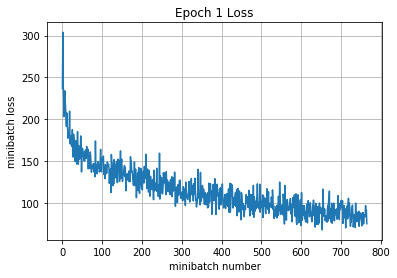

Iteration 800: with minibatch training loss = 1.1 and accuracy of 0.78
Iteration 900: with minibatch training loss = 1.34 and accuracy of 0.62
Iteration 1000: with minibatch training loss = 1.17 and accuracy of 0.72
Iteration 1100: with minibatch training loss = 1.13 and accuracy of 0.75
Iteration 1200: with minibatch training loss = 1.15 and accuracy of 0.69
Iteration 1300: with minibatch training loss = 0.789 and accuracy of 0.84
Iteration 1400: with minibatch training loss = 1.15 and accuracy of 0.62
Iteration 1500: with minibatch training loss = 0.839 and accuracy of 0.77
Epoch 2, Overall loss = 1.07 and accuracy of 0.733


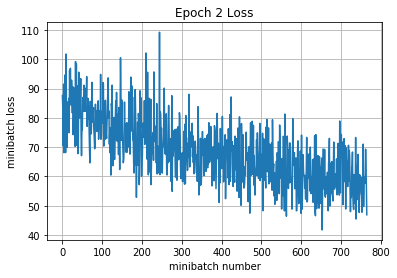

Iteration 1600: with minibatch training loss = 0.722 and accuracy of 0.86
Iteration 1700: with minibatch training loss = 0.862 and accuracy of 0.75
Iteration 1800: with minibatch training loss = 0.806 and accuracy of 0.78
Iteration 1900: with minibatch training loss = 0.903 and accuracy of 0.8
Iteration 2000: with minibatch training loss = 0.762 and accuracy of 0.77
Iteration 2100: with minibatch training loss = 0.567 and accuracy of 0.89
Iteration 2200: with minibatch training loss = 0.523 and accuracy of 0.91
Epoch 3, Overall loss = 0.74 and accuracy of 0.834


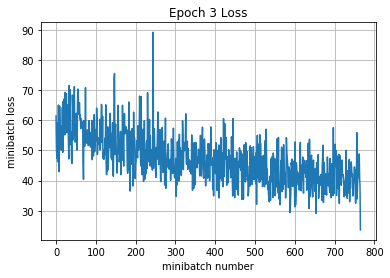

Iteration 2300: with minibatch training loss = 0.493 and accuracy of 0.92
Iteration 2400: with minibatch training loss = 0.697 and accuracy of 0.86
Iteration 2500: with minibatch training loss = 0.49 and accuracy of 0.94
Iteration 2600: with minibatch training loss = 0.438 and accuracy of 0.97
Iteration 2700: with minibatch training loss = 0.572 and accuracy of 0.92
Iteration 2800: with minibatch training loss = 0.433 and accuracy of 0.95
Iteration 2900: with minibatch training loss = 0.353 and accuracy of 1
Epoch 4, Overall loss = 0.423 and accuracy of 0.714


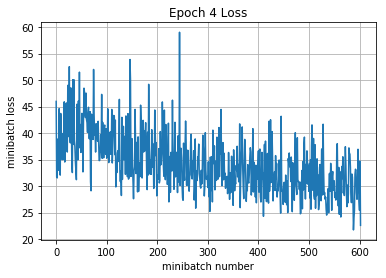

Iteration 2900: with minibatch training loss = 0.627 and accuracy of 0.86
Iteration 3000: with minibatch training loss = 0.404 and accuracy of 0.97
Iteration 3100: with minibatch training loss = 0.39 and accuracy of 0.95
Iteration 3200: with minibatch training loss = 0.375 and accuracy of 0.95
Iteration 3300: with minibatch training loss = 0.434 and accuracy of 0.95
Iteration 3400: with minibatch training loss = 0.389 and accuracy of 0.97
Iteration 3500: with minibatch training loss = 0.357 and accuracy of 0.98
Epoch 5, Overall loss = 0.326 and accuracy of 0.748


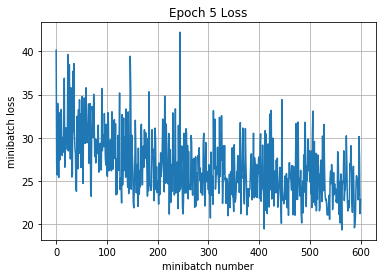

Iteration 3500: with minibatch training loss = 0.506 and accuracy of 0.89
Iteration 3600: with minibatch training loss = 0.345 and accuracy of 0.98
Epoch 6, Overall loss = 0.0508 and accuracy of 0.127


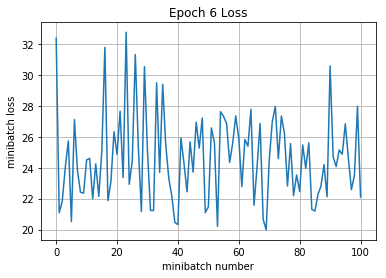

Iteration 3600: with minibatch training loss = 0.449 and accuracy of 0.92
Iteration 3700: with minibatch training loss = 0.314 and accuracy of 0.98
Epoch 7, Overall loss = 0.0438 and accuracy of 0.13


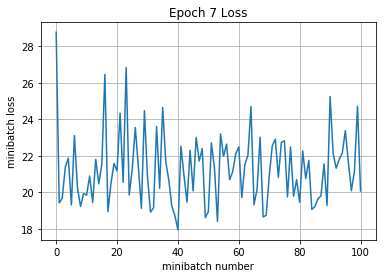

Iteration 3700: with minibatch training loss = 0.403 and accuracy of 0.97
Iteration 3800: with minibatch training loss = 0.294 and accuracy of 1
Epoch 8, Overall loss = 0.0403 and accuracy of 0.131


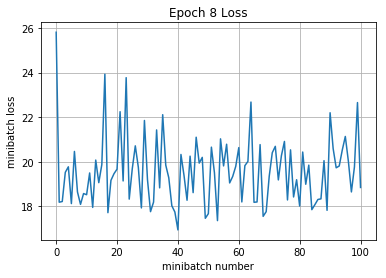

Iteration 3800: with minibatch training loss = 0.373 and accuracy of 0.97
Iteration 3900: with minibatch training loss = 0.281 and accuracy of 1
Epoch 9, Overall loss = 0.038 and accuracy of 0.131


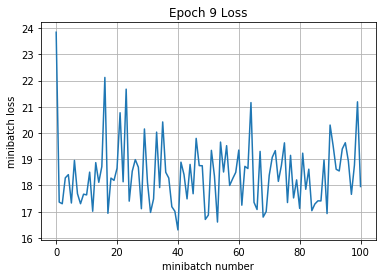

Iteration 3900: with minibatch training loss = 0.35 and accuracy of 0.98
Epoch 10, Overall loss = 0.000457 and accuracy of 0.00129


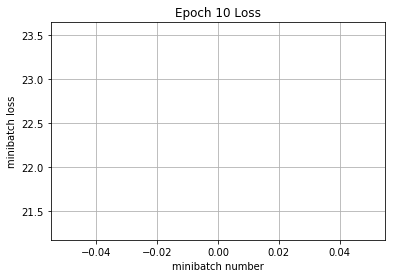

Validation
Epoch 1, Overall loss = 0.914 and accuracy of 0.764
Training
Iteration 0: with minibatch training loss = 3.45 and accuracy of 0.12
Iteration 100: with minibatch training loss = 2.13 and accuracy of 0.5
Iteration 200: with minibatch training loss = 2.27 and accuracy of 0.52
Iteration 300: with minibatch training loss = 1.82 and accuracy of 0.59
Iteration 400: with minibatch training loss = 1.68 and accuracy of 0.62
Iteration 500: with minibatch training loss = 1.52 and accuracy of 0.67
Iteration 600: with minibatch training loss = 1.46 and accuracy of 0.61
Iteration 700: with minibatch training loss = 1.44 and accuracy of 0.66
Epoch 1, Overall loss = 1.79 and accuracy of 0.586


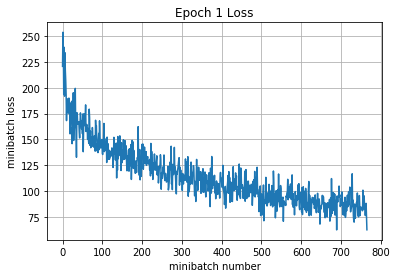

Iteration 800: with minibatch training loss = 1.28 and accuracy of 0.66
Iteration 900: with minibatch training loss = 1.15 and accuracy of 0.72
Iteration 1000: with minibatch training loss = 0.981 and accuracy of 0.77
Iteration 1100: with minibatch training loss = 0.873 and accuracy of 0.81
Iteration 1200: with minibatch training loss = 0.98 and accuracy of 0.69
Iteration 1300: with minibatch training loss = 1.06 and accuracy of 0.73
Iteration 1400: with minibatch training loss = 0.85 and accuracy of 0.83
Iteration 1500: with minibatch training loss = 1 and accuracy of 0.7
Epoch 2, Overall loss = 1.06 and accuracy of 0.736


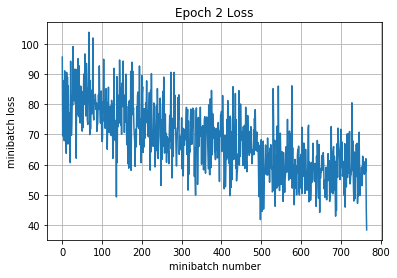

Iteration 1600: with minibatch training loss = 1.03 and accuracy of 0.69
Iteration 1700: with minibatch training loss = 0.817 and accuracy of 0.78
Iteration 1800: with minibatch training loss = 0.648 and accuracy of 0.91
Iteration 1900: with minibatch training loss = 0.899 and accuracy of 0.78
Iteration 2000: with minibatch training loss = 0.659 and accuracy of 0.83
Iteration 2100: with minibatch training loss = 0.654 and accuracy of 0.88
Iteration 2200: with minibatch training loss = 0.691 and accuracy of 0.88
Epoch 3, Overall loss = 0.729 and accuracy of 0.843


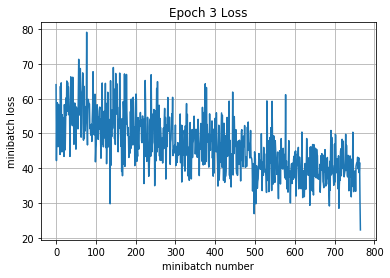

Iteration 2300: with minibatch training loss = 0.566 and accuracy of 0.84
Iteration 2400: with minibatch training loss = 0.564 and accuracy of 0.89
Iteration 2500: with minibatch training loss = 0.653 and accuracy of 0.89
Iteration 2600: with minibatch training loss = 0.44 and accuracy of 0.95
Iteration 2700: with minibatch training loss = 0.486 and accuracy of 0.92
Iteration 2800: with minibatch training loss = 0.342 and accuracy of 0.98
Epoch 4, Overall loss = 0.353 and accuracy of 0.599


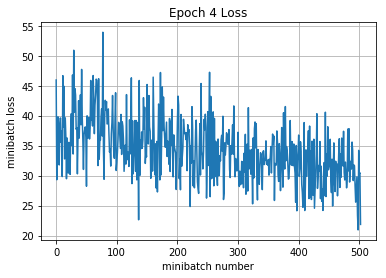

Iteration 2800: with minibatch training loss = 0.486 and accuracy of 0.94
Iteration 2900: with minibatch training loss = 0.358 and accuracy of 0.98
Epoch 5, Overall loss = 0.0585 and accuracy of 0.125


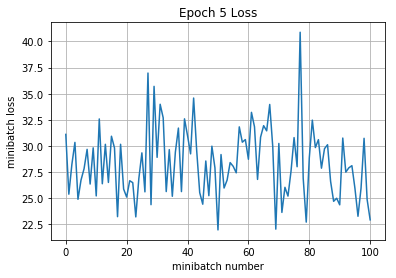

Iteration 2900: with minibatch training loss = 0.385 and accuracy of 0.98
Epoch 6, Overall loss = 0.000502 and accuracy of 0.00129


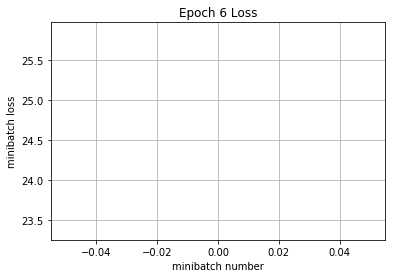

Iteration 2900: with minibatch training loss = 0.376 and accuracy of 0.98
Epoch 7, Overall loss = 0.00049 and accuracy of 0.00129


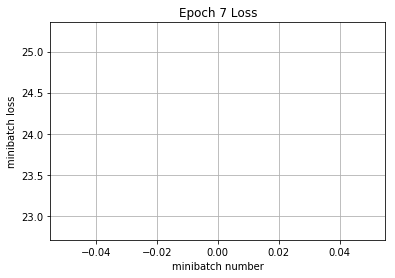

Iteration 2900: with minibatch training loss = 0.36 and accuracy of 0.98
Epoch 8, Overall loss = 0.00047 and accuracy of 0.00129


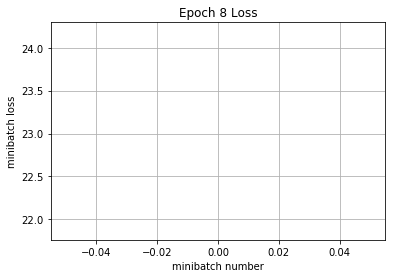

Iteration 2900: with minibatch training loss = 0.34 and accuracy of 0.98
Epoch 9, Overall loss = 0.000445 and accuracy of 0.00129


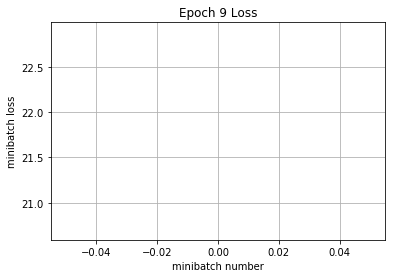

Iteration 2900: with minibatch training loss = 0.32 and accuracy of 1
Epoch 10, Overall loss = 0.000419 and accuracy of 0.00131


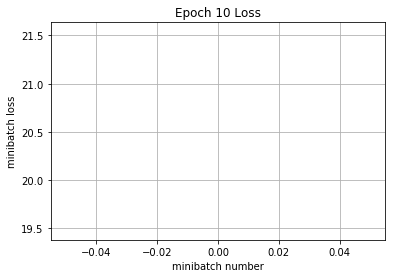

Validation
Epoch 1, Overall loss = 0.969 and accuracy of 0.753
Training
Iteration 0: with minibatch training loss = 3.74 and accuracy of 0.078
Iteration 100: with minibatch training loss = 2.21 and accuracy of 0.47
Iteration 200: with minibatch training loss = 1.77 and accuracy of 0.58
Iteration 300: with minibatch training loss = 1.86 and accuracy of 0.55
Iteration 400: with minibatch training loss = 1.66 and accuracy of 0.56
Iteration 500: with minibatch training loss = 1.45 and accuracy of 0.59
Iteration 600: with minibatch training loss = 1.49 and accuracy of 0.64
Iteration 700: with minibatch training loss = 1.1 and accuracy of 0.75
Epoch 1, Overall loss = 1.79 and accuracy of 0.578


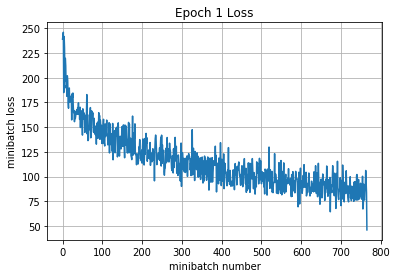

Iteration 800: with minibatch training loss = 1.19 and accuracy of 0.72
Iteration 900: with minibatch training loss = 1.5 and accuracy of 0.56
Iteration 1000: with minibatch training loss = 1.37 and accuracy of 0.66
Iteration 1100: with minibatch training loss = 1.04 and accuracy of 0.75
Iteration 1200: with minibatch training loss = 1.08 and accuracy of 0.7
Iteration 1300: with minibatch training loss = 0.992 and accuracy of 0.75
Iteration 1400: with minibatch training loss = 1.06 and accuracy of 0.7
Iteration 1500: with minibatch training loss = 0.916 and accuracy of 0.78
Epoch 2, Overall loss = 1.07 and accuracy of 0.73


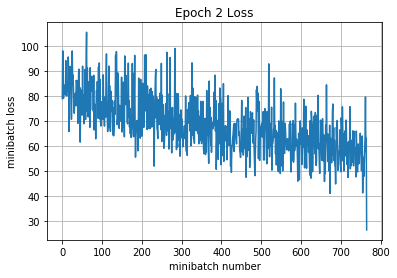

Iteration 1600: with minibatch training loss = 0.928 and accuracy of 0.7
Iteration 1700: with minibatch training loss = 0.762 and accuracy of 0.8
Iteration 1800: with minibatch training loss = 0.653 and accuracy of 0.84
Iteration 1900: with minibatch training loss = 0.652 and accuracy of 0.84
Iteration 2000: with minibatch training loss = 0.562 and accuracy of 0.92
Iteration 2100: with minibatch training loss = 0.602 and accuracy of 0.89
Iteration 2200: with minibatch training loss = 0.74 and accuracy of 0.84
Epoch 3, Overall loss = 0.746 and accuracy of 0.831


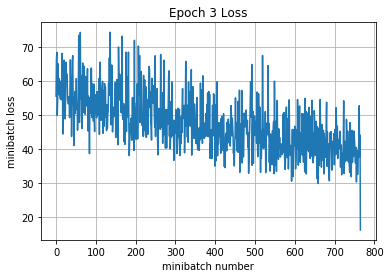

Iteration 2300: with minibatch training loss = 0.725 and accuracy of 0.78
Iteration 2400: with minibatch training loss = 0.523 and accuracy of 0.91
Iteration 2500: with minibatch training loss = 0.581 and accuracy of 0.89
Iteration 2600: with minibatch training loss = 0.625 and accuracy of 0.86
Iteration 2700: with minibatch training loss = 0.43 and accuracy of 0.92
Iteration 2800: with minibatch training loss = 0.524 and accuracy of 0.89
Iteration 2900: with minibatch training loss = 0.405 and accuracy of 0.97
Iteration 3000: with minibatch training loss = 0.455 and accuracy of 0.97
Epoch 4, Overall loss = 0.525 and accuracy of 0.911


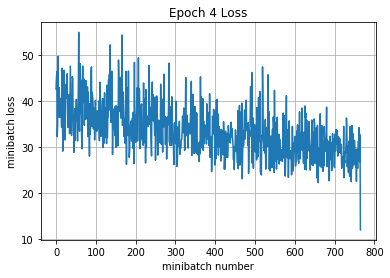

Iteration 3100: with minibatch training loss = 0.535 and accuracy of 0.94
Iteration 3200: with minibatch training loss = 0.598 and accuracy of 0.89
Iteration 3300: with minibatch training loss = 0.414 and accuracy of 0.95
Iteration 3400: with minibatch training loss = 0.398 and accuracy of 0.95
Iteration 3500: with minibatch training loss = 0.401 and accuracy of 0.95
Iteration 3600: with minibatch training loss = 0.343 and accuracy of 0.97
Iteration 3700: with minibatch training loss = 0.442 and accuracy of 0.97
Iteration 3800: with minibatch training loss = 0.402 and accuracy of 0.92
Epoch 5, Overall loss = 0.407 and accuracy of 0.955


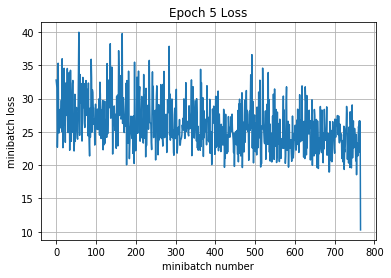

Iteration 3900: with minibatch training loss = 0.423 and accuracy of 0.95
Iteration 4000: with minibatch training loss = 0.359 and accuracy of 0.97
Iteration 4100: with minibatch training loss = 0.351 and accuracy of 0.95
Iteration 4200: with minibatch training loss = 0.293 and accuracy of 1
Epoch 6, Overall loss = 0.176 and accuracy of 0.469


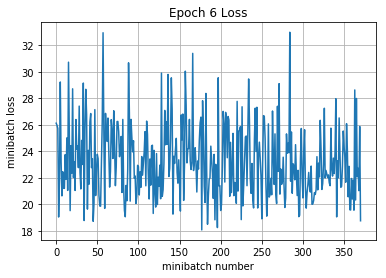

Iteration 4200: with minibatch training loss = 0.356 and accuracy of 0.98
Epoch 7, Overall loss = 0.000465 and accuracy of 0.00129


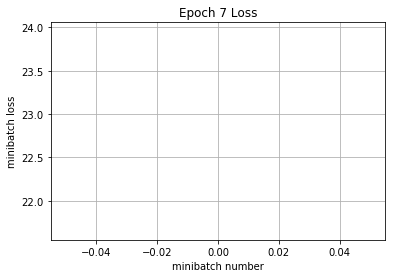

Iteration 4200: with minibatch training loss = 0.353 and accuracy of 0.98
Epoch 8, Overall loss = 0.000461 and accuracy of 0.00129


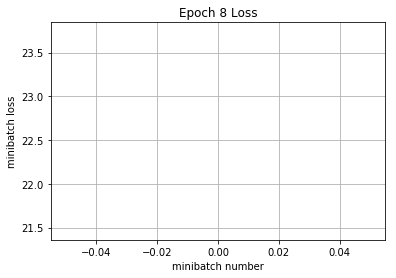

Iteration 4200: with minibatch training loss = 0.347 and accuracy of 0.98
Epoch 9, Overall loss = 0.000454 and accuracy of 0.00129


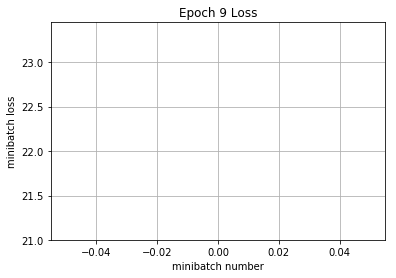

Iteration 4200: with minibatch training loss = 0.339 and accuracy of 0.98
Epoch 10, Overall loss = 0.000443 and accuracy of 0.00129


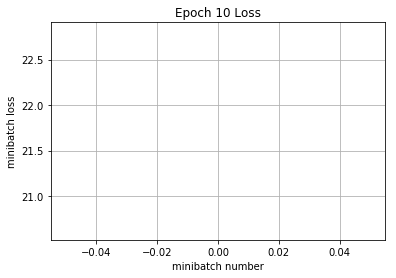

Validation
Epoch 1, Overall loss = 0.888 and accuracy of 0.759
Training
Iteration 0: with minibatch training loss = 3.48 and accuracy of 0.12
Iteration 100: with minibatch training loss = 2.15 and accuracy of 0.53
Iteration 200: with minibatch training loss = 2.03 and accuracy of 0.58
Iteration 300: with minibatch training loss = 1.73 and accuracy of 0.64
Iteration 400: with minibatch training loss = 1.82 and accuracy of 0.55
Iteration 500: with minibatch training loss = 1.47 and accuracy of 0.61
Iteration 600: with minibatch training loss = 1.45 and accuracy of 0.66
Iteration 700: with minibatch training loss = 1.24 and accuracy of 0.7
Epoch 1, Overall loss = 1.8 and accuracy of 0.575


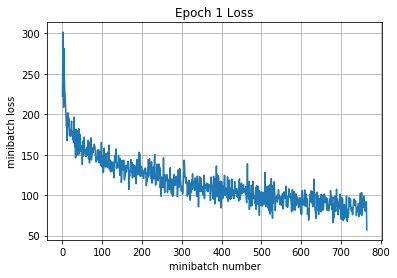

Iteration 800: with minibatch training loss = 1.18 and accuracy of 0.69
Iteration 900: with minibatch training loss = 1.34 and accuracy of 0.7
Iteration 1000: with minibatch training loss = 1.05 and accuracy of 0.8
Iteration 1100: with minibatch training loss = 1.05 and accuracy of 0.72
Iteration 1200: with minibatch training loss = 1.08 and accuracy of 0.73
Iteration 1300: with minibatch training loss = 1.1 and accuracy of 0.67
Iteration 1400: with minibatch training loss = 1.14 and accuracy of 0.7
Iteration 1500: with minibatch training loss = 1.05 and accuracy of 0.77
Epoch 2, Overall loss = 1.07 and accuracy of 0.73


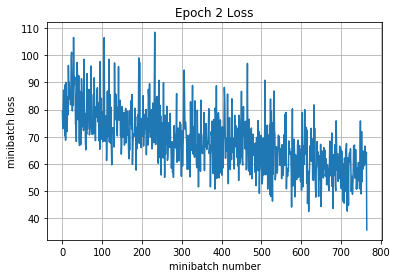

Iteration 1600: with minibatch training loss = 0.843 and accuracy of 0.78
Iteration 1700: with minibatch training loss = 0.89 and accuracy of 0.72
Iteration 1800: with minibatch training loss = 0.692 and accuracy of 0.88
Iteration 1900: with minibatch training loss = 0.851 and accuracy of 0.77
Iteration 2000: with minibatch training loss = 0.644 and accuracy of 0.88
Iteration 2100: with minibatch training loss = 0.584 and accuracy of 0.89
Iteration 2200: with minibatch training loss = 0.599 and accuracy of 0.89
Epoch 3, Overall loss = 0.737 and accuracy of 0.835


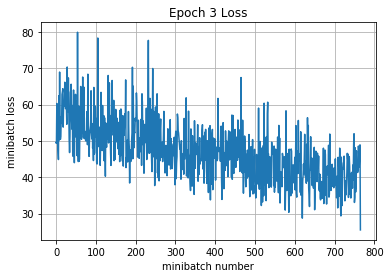

Iteration 2300: with minibatch training loss = 0.701 and accuracy of 0.84
Iteration 2400: with minibatch training loss = 0.476 and accuracy of 0.94
Iteration 2500: with minibatch training loss = 0.648 and accuracy of 0.83
Iteration 2600: with minibatch training loss = 0.425 and accuracy of 0.92
Iteration 2700: with minibatch training loss = 0.485 and accuracy of 0.95
Iteration 2800: with minibatch training loss = 0.383 and accuracy of 0.97
Iteration 2900: with minibatch training loss = 0.527 and accuracy of 0.91
Iteration 3000: with minibatch training loss = 0.505 and accuracy of 0.91
Epoch 4, Overall loss = 0.514 and accuracy of 0.918


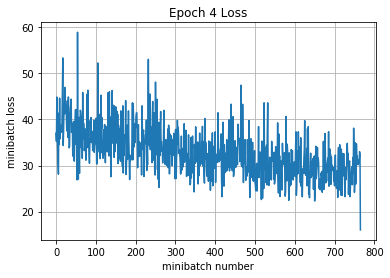

Iteration 3100: with minibatch training loss = 0.459 and accuracy of 0.91
Iteration 3200: with minibatch training loss = 0.405 and accuracy of 0.95
Iteration 3300: with minibatch training loss = 0.523 and accuracy of 0.91
Iteration 3400: with minibatch training loss = 0.368 and accuracy of 0.95
Iteration 3500: with minibatch training loss = 0.362 and accuracy of 0.97
Iteration 3600: with minibatch training loss = 0.338 and accuracy of 1
Epoch 5, Overall loss = 0.287 and accuracy of 0.67


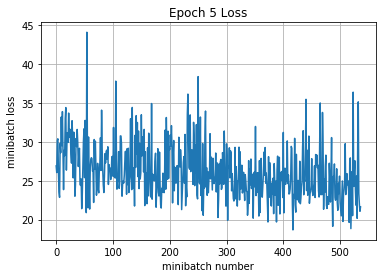

Iteration 3600: with minibatch training loss = 0.388 and accuracy of 0.95
Iteration 3700: with minibatch training loss = 0.33 and accuracy of 0.98
Epoch 6, Overall loss = 0.0484 and accuracy of 0.128


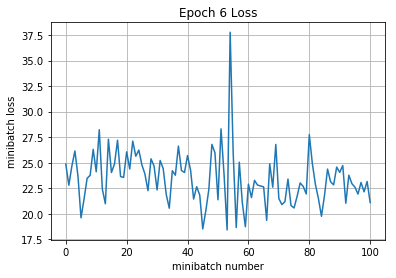

Iteration 3700: with minibatch training loss = 0.317 and accuracy of 0.98
Epoch 7, Overall loss = 0.000414 and accuracy of 0.00129


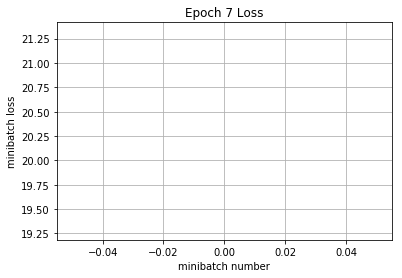

Iteration 3700: with minibatch training loss = 0.315 and accuracy of 0.98
Epoch 8, Overall loss = 0.000411 and accuracy of 0.00129


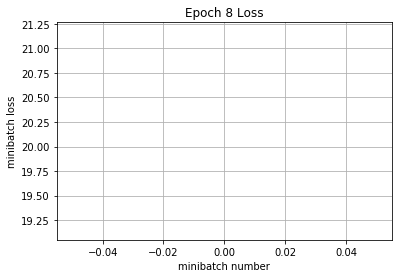

Iteration 3700: with minibatch training loss = 0.31 and accuracy of 0.98
Epoch 9, Overall loss = 0.000405 and accuracy of 0.00129


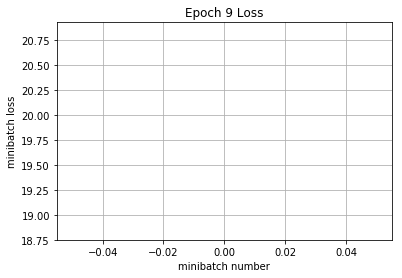

Iteration 3700: with minibatch training loss = 0.303 and accuracy of 0.98
Epoch 10, Overall loss = 0.000396 and accuracy of 0.00129


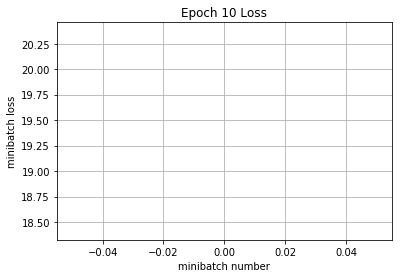

Validation
Epoch 1, Overall loss = 0.862 and accuracy of 0.773
Training
Iteration 0: with minibatch training loss = 3.53 and accuracy of 0.12
Iteration 100: with minibatch training loss = 2.12 and accuracy of 0.52
Iteration 200: with minibatch training loss = 1.86 and accuracy of 0.58
Iteration 300: with minibatch training loss = 1.87 and accuracy of 0.48
Iteration 400: with minibatch training loss = 1.61 and accuracy of 0.64
Iteration 500: with minibatch training loss = 1.78 and accuracy of 0.56
Iteration 600: with minibatch training loss = 1.38 and accuracy of 0.7
Iteration 700: with minibatch training loss = 1.06 and accuracy of 0.73
Epoch 1, Overall loss = 1.79 and accuracy of 0.579


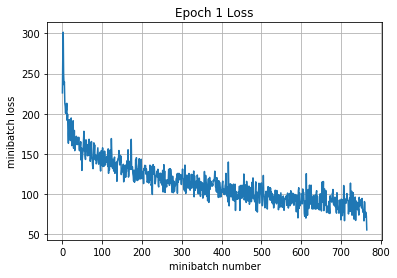

Iteration 800: with minibatch training loss = 1.34 and accuracy of 0.67
Iteration 900: with minibatch training loss = 1.17 and accuracy of 0.75
Iteration 1000: with minibatch training loss = 0.968 and accuracy of 0.77
Iteration 1100: with minibatch training loss = 1.08 and accuracy of 0.69
Iteration 1200: with minibatch training loss = 1.05 and accuracy of 0.73
Iteration 1300: with minibatch training loss = 0.93 and accuracy of 0.75
Iteration 1400: with minibatch training loss = 1.06 and accuracy of 0.66
Iteration 1500: with minibatch training loss = 0.743 and accuracy of 0.83
Epoch 2, Overall loss = 1.08 and accuracy of 0.731


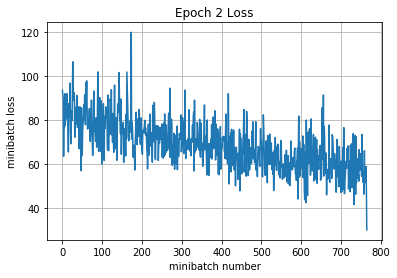

Iteration 1600: with minibatch training loss = 0.962 and accuracy of 0.77
Iteration 1700: with minibatch training loss = 0.874 and accuracy of 0.81
Iteration 1800: with minibatch training loss = 0.772 and accuracy of 0.83
Iteration 1900: with minibatch training loss = 0.582 and accuracy of 0.91
Iteration 2000: with minibatch training loss = 0.648 and accuracy of 0.83
Iteration 2100: with minibatch training loss = 0.584 and accuracy of 0.94
Iteration 2200: with minibatch training loss = 0.519 and accuracy of 0.95
Epoch 3, Overall loss = 0.747 and accuracy of 0.834


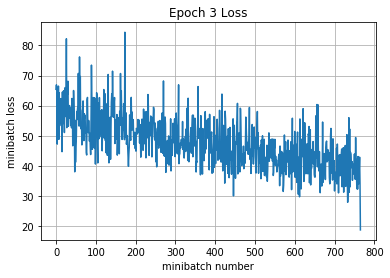

Iteration 2300: with minibatch training loss = 0.685 and accuracy of 0.86
Iteration 2400: with minibatch training loss = 0.708 and accuracy of 0.8
Iteration 2500: with minibatch training loss = 0.563 and accuracy of 0.91
Iteration 2600: with minibatch training loss = 0.609 and accuracy of 0.84
Iteration 2700: with minibatch training loss = 0.524 and accuracy of 0.95
Iteration 2800: with minibatch training loss = 0.432 and accuracy of 0.95
Iteration 2900: with minibatch training loss = 0.505 and accuracy of 0.95
Iteration 3000: with minibatch training loss = 0.408 and accuracy of 0.94
Epoch 4, Overall loss = 0.527 and accuracy of 0.913


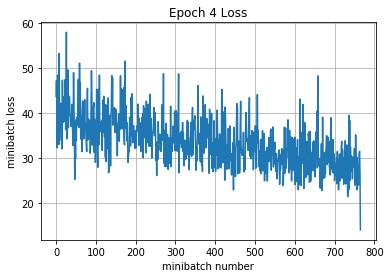

Iteration 3100: with minibatch training loss = 0.43 and accuracy of 0.97
Iteration 3200: with minibatch training loss = 0.478 and accuracy of 0.95
Iteration 3300: with minibatch training loss = 0.585 and accuracy of 0.89
Iteration 3400: with minibatch training loss = 0.374 and accuracy of 0.98
Epoch 5, Overall loss = 0.191 and accuracy of 0.416


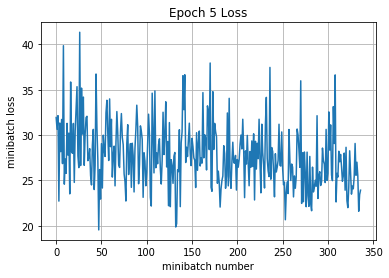

Iteration 3400: with minibatch training loss = 0.41 and accuracy of 0.98
Epoch 6, Overall loss = 0.000535 and accuracy of 0.00129


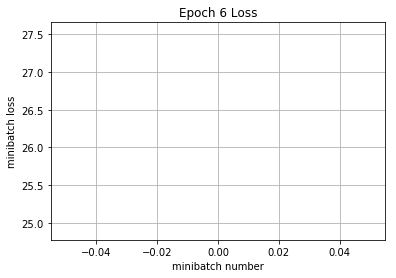

Iteration 3400: with minibatch training loss = 0.402 and accuracy of 0.98
Epoch 7, Overall loss = 0.000525 and accuracy of 0.00129


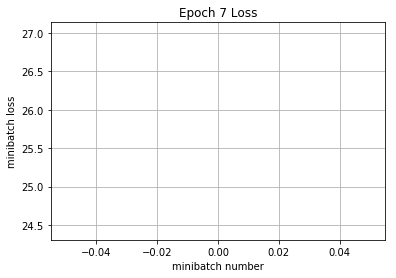

Iteration 3400: with minibatch training loss = 0.388 and accuracy of 1
Epoch 8, Overall loss = 0.000507 and accuracy of 0.00131


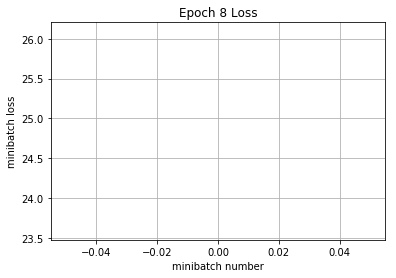

Iteration 3400: with minibatch training loss = 0.37 and accuracy of 1
Epoch 9, Overall loss = 0.000484 and accuracy of 0.00131


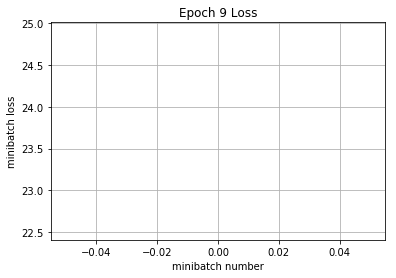

Iteration 3400: with minibatch training loss = 0.351 and accuracy of 1
Epoch 10, Overall loss = 0.000458 and accuracy of 0.00131


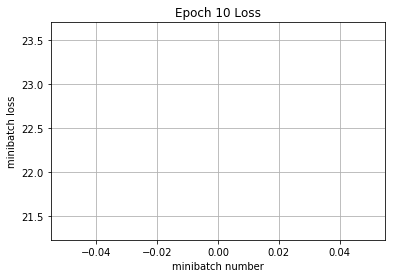

Validation
Epoch 1, Overall loss = 0.914 and accuracy of 0.756
Training
Iteration 0: with minibatch training loss = 3.53 and accuracy of 0.094
Iteration 100: with minibatch training loss = 2.23 and accuracy of 0.48
Iteration 200: with minibatch training loss = 1.85 and accuracy of 0.59
Iteration 300: with minibatch training loss = 1.78 and accuracy of 0.64
Iteration 400: with minibatch training loss = 1.68 and accuracy of 0.66
Iteration 500: with minibatch training loss = 1.39 and accuracy of 0.66
Iteration 600: with minibatch training loss = 1.34 and accuracy of 0.77
Iteration 700: with minibatch training loss = 1.32 and accuracy of 0.67
Epoch 1, Overall loss = 1.8 and accuracy of 0.583


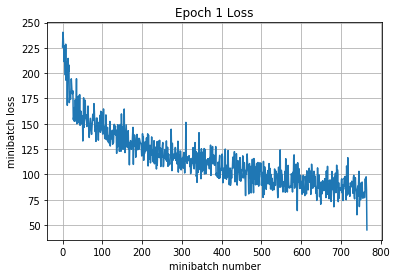

Iteration 800: with minibatch training loss = 1.19 and accuracy of 0.72
Iteration 900: with minibatch training loss = 1.14 and accuracy of 0.72
Iteration 1000: with minibatch training loss = 1.11 and accuracy of 0.75
Iteration 1100: with minibatch training loss = 1.01 and accuracy of 0.83
Iteration 1200: with minibatch training loss = 0.967 and accuracy of 0.75
Iteration 1300: with minibatch training loss = 1.11 and accuracy of 0.75
Iteration 1400: with minibatch training loss = 1.09 and accuracy of 0.8
Iteration 1500: with minibatch training loss = 0.748 and accuracy of 0.86
Epoch 2, Overall loss = 1.06 and accuracy of 0.737


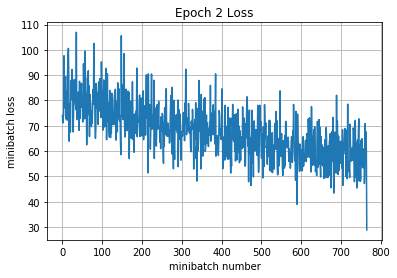

Iteration 1600: with minibatch training loss = 0.729 and accuracy of 0.84
Iteration 1700: with minibatch training loss = 0.628 and accuracy of 0.89
Iteration 1800: with minibatch training loss = 0.706 and accuracy of 0.84
Iteration 1900: with minibatch training loss = 0.684 and accuracy of 0.84
Iteration 2000: with minibatch training loss = 0.532 and accuracy of 0.89
Iteration 2100: with minibatch training loss = 0.74 and accuracy of 0.84
Iteration 2200: with minibatch training loss = 0.627 and accuracy of 0.84
Epoch 3, Overall loss = 0.726 and accuracy of 0.842


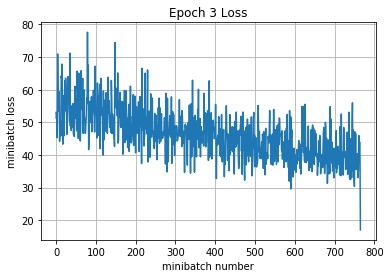

Iteration 2300: with minibatch training loss = 0.596 and accuracy of 0.84
Iteration 2400: with minibatch training loss = 0.505 and accuracy of 0.92
Iteration 2500: with minibatch training loss = 0.586 and accuracy of 0.88
Iteration 2600: with minibatch training loss = 0.517 and accuracy of 0.92
Iteration 2700: with minibatch training loss = 0.486 and accuracy of 0.97


KeyboardInterrupt: 

In [41]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy

import time

def train():
    global sess
    sess = tf.Session()

    sess.run(tf.global_variables_initializer())
    print('Training')
    run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
    print('Validation')
    run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
    
    saver = tf.train.Saver()
    saver.save(sess, "./model%d.ckpt"%time.time())

while(1):
    train()

In [64]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
a,b,_ = run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
(a,b)

Training
Epoch 1, Overall loss = 0.318 and accuracy of 0.982
Validation
Epoch 1, Overall loss = 0.887 and accuracy of 0.771


(0.8869381833076477, 0.771)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

_Tell us here_

convolution, batchnorm, relu, max pool, convolution, batchnorm, relu max pool, fully connected

exponential decay of learning rate

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [32]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 0.892 and accuracy of 0.763


(0.8920305063247681, 0.7627)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.

1. the run model function have early termination when the training accuracy reach 98%
2. multiple model are trained for reference, and have a improve in performance of 2-3% accuracy (refer to extra.py)

In [34]:
#test save session

import time
saver = tf.train.Saver()
saver.save(sess, "./model%d.ckpt"%time.time())

'./model1539594715.ckpt'

In [62]:
#test load session

with tf.Session() as new_sess:
    saver.restore(new_sess,'./model1539594715.ckpt')
    run_model(new_sess,y_out,mean_loss,X_val,y_val,1,64)

INFO:tensorflow:Restoring parameters from ./model1539594715.ckpt
Epoch 1, Overall loss = 0.887 and accuracy of 0.771


In [60]:
# modify the run_model function

def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False, needShuffle = True):
    # have tensorflow compute accuracy
    prediction = tf.argmax(predict,1)
    correct_prediction = tf.equal(prediction, y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    if needShuffle: np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy,prediction]
    if training_now:
        variables[-1] = training    
    _pre = np.array([])

    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _, __pre = session.run(variables,feed_dict=feed_dict)
            if not training_now:
                _pre = np.concatenate((_pre,__pre))
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
                if np.sum(corr)/actual_batch_size >= 0.98:
                    break #the model reach the trainning optimal
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct,_pre

In [56]:
# load multiple models and test
# models are here: https://drive.google.com/open?id=1ZAUko8OsqYiHW0N81i1JrZ9HosIPS8JA
# put all models at the assignment root

links = [
  './model1539594715.ckpt',
  './model1539604193.ckpt',
  './model1539616437.ckpt',
  './model1539620015.ckpt',
  './model1539623326.ckpt',
  './model1539628351.ckpt',
  './model1539632040.ckpt',
  './model1539635508.ckpt',
  './model1539640535.ckpt',
  './model1539644068.ckpt',
  './model1539648107.ckpt',
  './model1539651922.ckpt',
  './model1539655746.ckpt',
  './model1539659236.ckpt',
  './model1539662734.ckpt',
  './model1539668023.ckpt',
  './model1539672415.ckpt',
  './model1539675574.ckpt',
  './model1539680202.ckpt',
    './model1539684872.ckpt',
    './model1539688714.ckpt'
]

M_cnt = len(links)

def load(link):
    with tf.Session() as new_sess:
        saver = tf.train.Saver()
        saver.restore(new_sess,link)
        a,b,c = run_model(new_sess,y_out,mean_loss,X_test,y_test,1,64,needShuffle=False)
        return c

ans = []
predict = []

for i in range(M_cnt):
    ans.append(load(links[i]))

# print(ans)
ans = np.array(ans,dtype='int64')

for i in range(ans.shape[1]):
    predict.append(np.bincount(ans[:,i]).argmax())

predict = np.array(predict)
num_correct = np.sum(predict==y_test)
num_total = ans.shape[1]
accuracy = float(num_correct)/num_total
print('Accuracy %f total correct%d out of %d'%(accuracy,num_correct,num_total))

INFO:tensorflow:Restoring parameters from ./model1539594715.ckpt
Epoch 1, Overall loss = 0.892 and accuracy of 0.763
INFO:tensorflow:Restoring parameters from ./model1539604193.ckpt
Epoch 1, Overall loss = 0.9 and accuracy of 0.761
INFO:tensorflow:Restoring parameters from ./model1539616437.ckpt
Epoch 1, Overall loss = 0.879 and accuracy of 0.768
INFO:tensorflow:Restoring parameters from ./model1539620015.ckpt
Epoch 1, Overall loss = 0.914 and accuracy of 0.763
INFO:tensorflow:Restoring parameters from ./model1539623326.ckpt
Epoch 1, Overall loss = 0.931 and accuracy of 0.752
INFO:tensorflow:Restoring parameters from ./model1539628351.ckpt
Epoch 1, Overall loss = 0.899 and accuracy of 0.764
INFO:tensorflow:Restoring parameters from ./model1539632040.ckpt
Epoch 1, Overall loss = 0.917 and accuracy of 0.756
INFO:tensorflow:Restoring parameters from ./model1539635508.ckpt
Epoch 1, Overall loss = 0.919 and accuracy of 0.755
INFO:tensorflow:Restoring parameters from ./model1539640535.ckpt
E